## LEMME TELL YOU HOW I MF'n SNAPPED BITCH

This code actually uses the distance from the max width to recover the actual distance/cross stream position and scales. For example, if the initial width, t0, is 10, (centreline at 0, Left Bank at 5, Right Bank at -5) and the final width is 20 (CL = 0m, LB = 10m, RB= -10m), the actual distance measure you'd use for plotting t0 is *actually* 5-15m, and tfin would be from 0-20? U know wat i mean jellybean?

ANYWAY, to be able to get the right indexing you need to actually download the full resuly csvs from NAYS, ~NOT~ the freakin' csvs from the graph window. The cool part about this though is that you can now plot any section u want, not just whatever exprots you predetermine, and well you can also pull out other data as well, so there is more flexibility here, which is actually a really big deal because that manual exportation is SUCH a timesink. 

now go forth, plot shit & b great

## Must start naming files @ 0!!

Hello all, and welcome to the shitshow--

This is the most recent version of the Strat Builder code, that includes:
1. plotting stratigraphy
2. delineating surfaces and ages of erosion, deposition and hiatus
3. the shear stress/velocity/flow depth/gradient facies models
4. heat maps showing the locus of the channel at every timestep
5. Wheeler diagram of the stratigraphy
6. Code to core stratigraphy, and pull out mean and max set thicknesses in time and space 
7. Centroids of each depositional package, grouped by vector of motion between timesteps (clunky)
8. Code to create 'field scale' stratigraphy using the percentile/% reworking method (described in a later ramble below)
9. Eventually-- code to do 5-8 for the new, field scale stratigraphy.

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import collections
import copy 

import PIL.Image
from xml.dom import minidom
from shapely.geometry import Polygon, MultiPolygon
#from descartes import PolygonPatch
#from PIL import Image
from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from celluloid import Camera
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

%matplotlib inline
#%matplotlib qt
#%matplotlib notebook
#from google.colab import drive
#drive.mount("/content/gdrive")

## Setting up all the aesthetics:
plot fonts, colourmaps (for timestep, shears tress facies and gradient) 

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)
kwargs = dict(edgecolor = 'k', fc = 'xkcd:greyish', alpha=0.5, bins=20)

In [3]:
 ## source of this function: http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html#code
def make_cmap(colors, position=None, bit=False):

    if len(position) != len(colors):
        sys.exit('position length must be the same as colors')
    elif position[0] != 0 or position[-1] != 1:
        sys.exit('position must start with 0 and end with 1')
    
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):

        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

        cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    return cmap

## load source xml file
xmldoc = minidom.parse('/Volumes/SAF_MSCWORK/Python/colourmaps/mellow-rainbow.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

mycmap = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')

#mycmap_r = ListedColormap(mycmap.colors[::-1])

# mycmap is matplotlib compatible object. to query color value out of it:

#print('example rgba value for data value 0 is: ' + str(mycmap(0.0)))

## load source xml file
xmldoc = minidom.parse('/Volumes/SAF_MSCWORK/Python/colourmaps/brown-2.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

ss_facies = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')

## load source xml file
xmldoc = minidom.parse('/Volumes/SAF_MSCWORK/Python/colourmaps/green-brown-div.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

grads = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')

xmldoc = minidom.parse('/Volumes/SAF_MSCWORK/Python/colourmaps/blue-3.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

depths = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')

##for velocities

xmldoc = minidom.parse('/Volumes/SAF_MSCWORK/Python/colourmaps/orange-6.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

vels = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')


xmldoc = minidom.parse('/Volumes/SAF_MSCWORK/Python/colourmaps/1-3wbgy.xml')
itemlist = xmldoc.getElementsByTagName('Point')
data_vals=[]
color_vals=[]

for s in itemlist:
    
    data_vals.append(float(s.attributes['x'].value))
    color_vals.append((float(s.attributes['r'].value),
    float(s.attributes['g'].value),
    float(s.attributes['b'].value)))

## construct the colormap

planformcmap = make_cmap(color_vals,data_vals) ##this is the main rainbow colourmap to be used in the code
print('converted successfully!')



converted successfully!
converted successfully!
converted successfully!
converted successfully!
converted successfully!
converted successfully!


In [4]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [5]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcol.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [6]:
planformcmap = reverse_colourmap(planformcmap)

In [7]:
ss_facies_r = reverse_colourmap(ss_facies)
timesteps_r = reverse_colourmap(mycmap)

Important model parameters that might be used in calculation:

In [8]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [9]:
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m
iloc = 630#location of the section along i axis
jloc = 14#location of the secion along j axis
thot_SS = 820800 #
#time from which we restarted the runs to add a flood
fldstart_s = 3600 ##start time of flood in seconds
fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '1hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

More model set up

In [10]:
datnam = f'{idf}-datamaster-{intstring}.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s
cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

## Import data

In [11]:
print(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

savefilesto = '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Plots/'
modelrun = f'{nickname}-hr-{fldlength}hrfld-{iloc}'

##define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/ConvertedArrays/data-agubh2-10km_0hrflood/0hfld-datamaster-1hour.npy
Shape of the datamaster dataset is:  (26026, 11, 399)


In [12]:
num_timesteps = datamaster.shape[2] ## or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ##when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 60/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ##flood starttime, s

print('Shape of data used to plot:', datamaster.shape)

Number of timesteps being used:  399
Shape of data used to plot: (26026, 11, 399)



## Plotting full model domain

Links for colourmap help

big up towards data science for the tutorial:
https://towardsdatascience.com/creating-colormaps-in-matplotlib-4d4de78a04b8

diy cmap from twoards data science, again: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

**Define colormaps here**

In [13]:
## DEFINE COLOURMAPS
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ['#0091ad', '#3fcdda', '#83f9f8', '#d6f6eb', '#fdf1d2', '#f8eaad', '#faaaae', '#ff57bb']
planform_colours = ['#3f9b0b', '#e2ca76', '#886806','02ccfe','#0485d1','#0504aa', ] 
                ##grass green, sand, shit, muddy brown, turquoise, cerulean, royal blue 

temperate= ['3f9b0b', 'bf9005', '02ccfe','3c9992', '0485d1', '0504aa' ] #ugly and green and glue
                    #dark tan, sand, sea green, cerulean, navy blue
test = ['a75e09','bd6c48', 'af884a', 'cb7723','7bc8f6','069af3', '0e87cc', '2242c77', '0504aa', '00035b'] 
#raw umber, adobe, dark tan, brownish orange, light blue, azure, water blue,  blue blue, royal blue, dark blue    
#test  = ['bd6c48','cb7723','ad8150', '0e87cc', '0504aa', '00035b']
#adobe, brownish orange, dark tan, light brown,water blue, royal blue, dark blue
glacial = ['ffffcb', 'e2ca76','bf9005', '7f5e00','6dedfd', '02ccfe','0504aa']
#dark sand, light grey, stone, azure, navy blue
redyellow = ['cf0234','e50000','ffffff', 'ffff14', 'fec615']
#cherry, red, white, yellow, golden yellow
redblue = ['cf0234','e50000', 'ffffff','152eff', '0203e2']
redblue_r = ['0203e2', '152eff','ffffff', 'e50000', 'cf0234']
yellowblue = ['fec615', 'ffff14', 'ffffff','152eff', '0203e2']
centrelines = ['ffffff', '000000']
#cherry, red, white, vivid blue, pure blue

In [14]:
## find the indices for preflood and post flood

pref_idx = int(np.floor(fldstart)) ##index of time at pre flood
post_idx = int(np.floor((((thot_SS+fldstart_s)/3600)+fldlength)/interval_to_plot)) ##index of time at post flood

print("Flood start at timestep: ", pref_idx)
print("Flood ends at: ", post_idx)

Flood start at timestep:  229
Flood ends at:  229


/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


attribute top: 0.76. Midpoint: 0.47


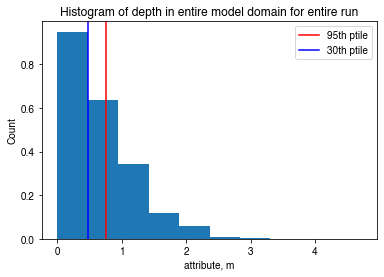

In [15]:
char = 10 ## what do you want to colour by? flow depth (4), elevation change (7) etc
attribs = datamaster[:, char, :].ravel() # scaling to find your normalisation for the attribute/char you choose to colour with
avattribs = np.average(attribs)
locd = np.average(avattribs)
scd = np.std(avattribs)
attx = np.linspace(attribs.min(), attribs.max())
apdf = stats.norm.pdf(attx, locd, scd)
plt.hist(attribs, density=True);

toplim = np.quantile(attribs, 0.65)
lowlim = np.quantile(attribs, 0.45)
plt.axvline(toplim, c = 'r', label = '95th ptile')
plt.axvline(lowlim, c = 'b', label = '30th ptile')
plt.xlabel('attribute, m')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of depth in entire model domain for entire run');
print(f'attribute top: {np.round(toplim, 2)}. Midpoint: {np.round(lowlim, 2)}')

For the colourbar and filling in the model domain plots, we are plotting scaled to the 95th percentile depth

0.0 4.7279591032


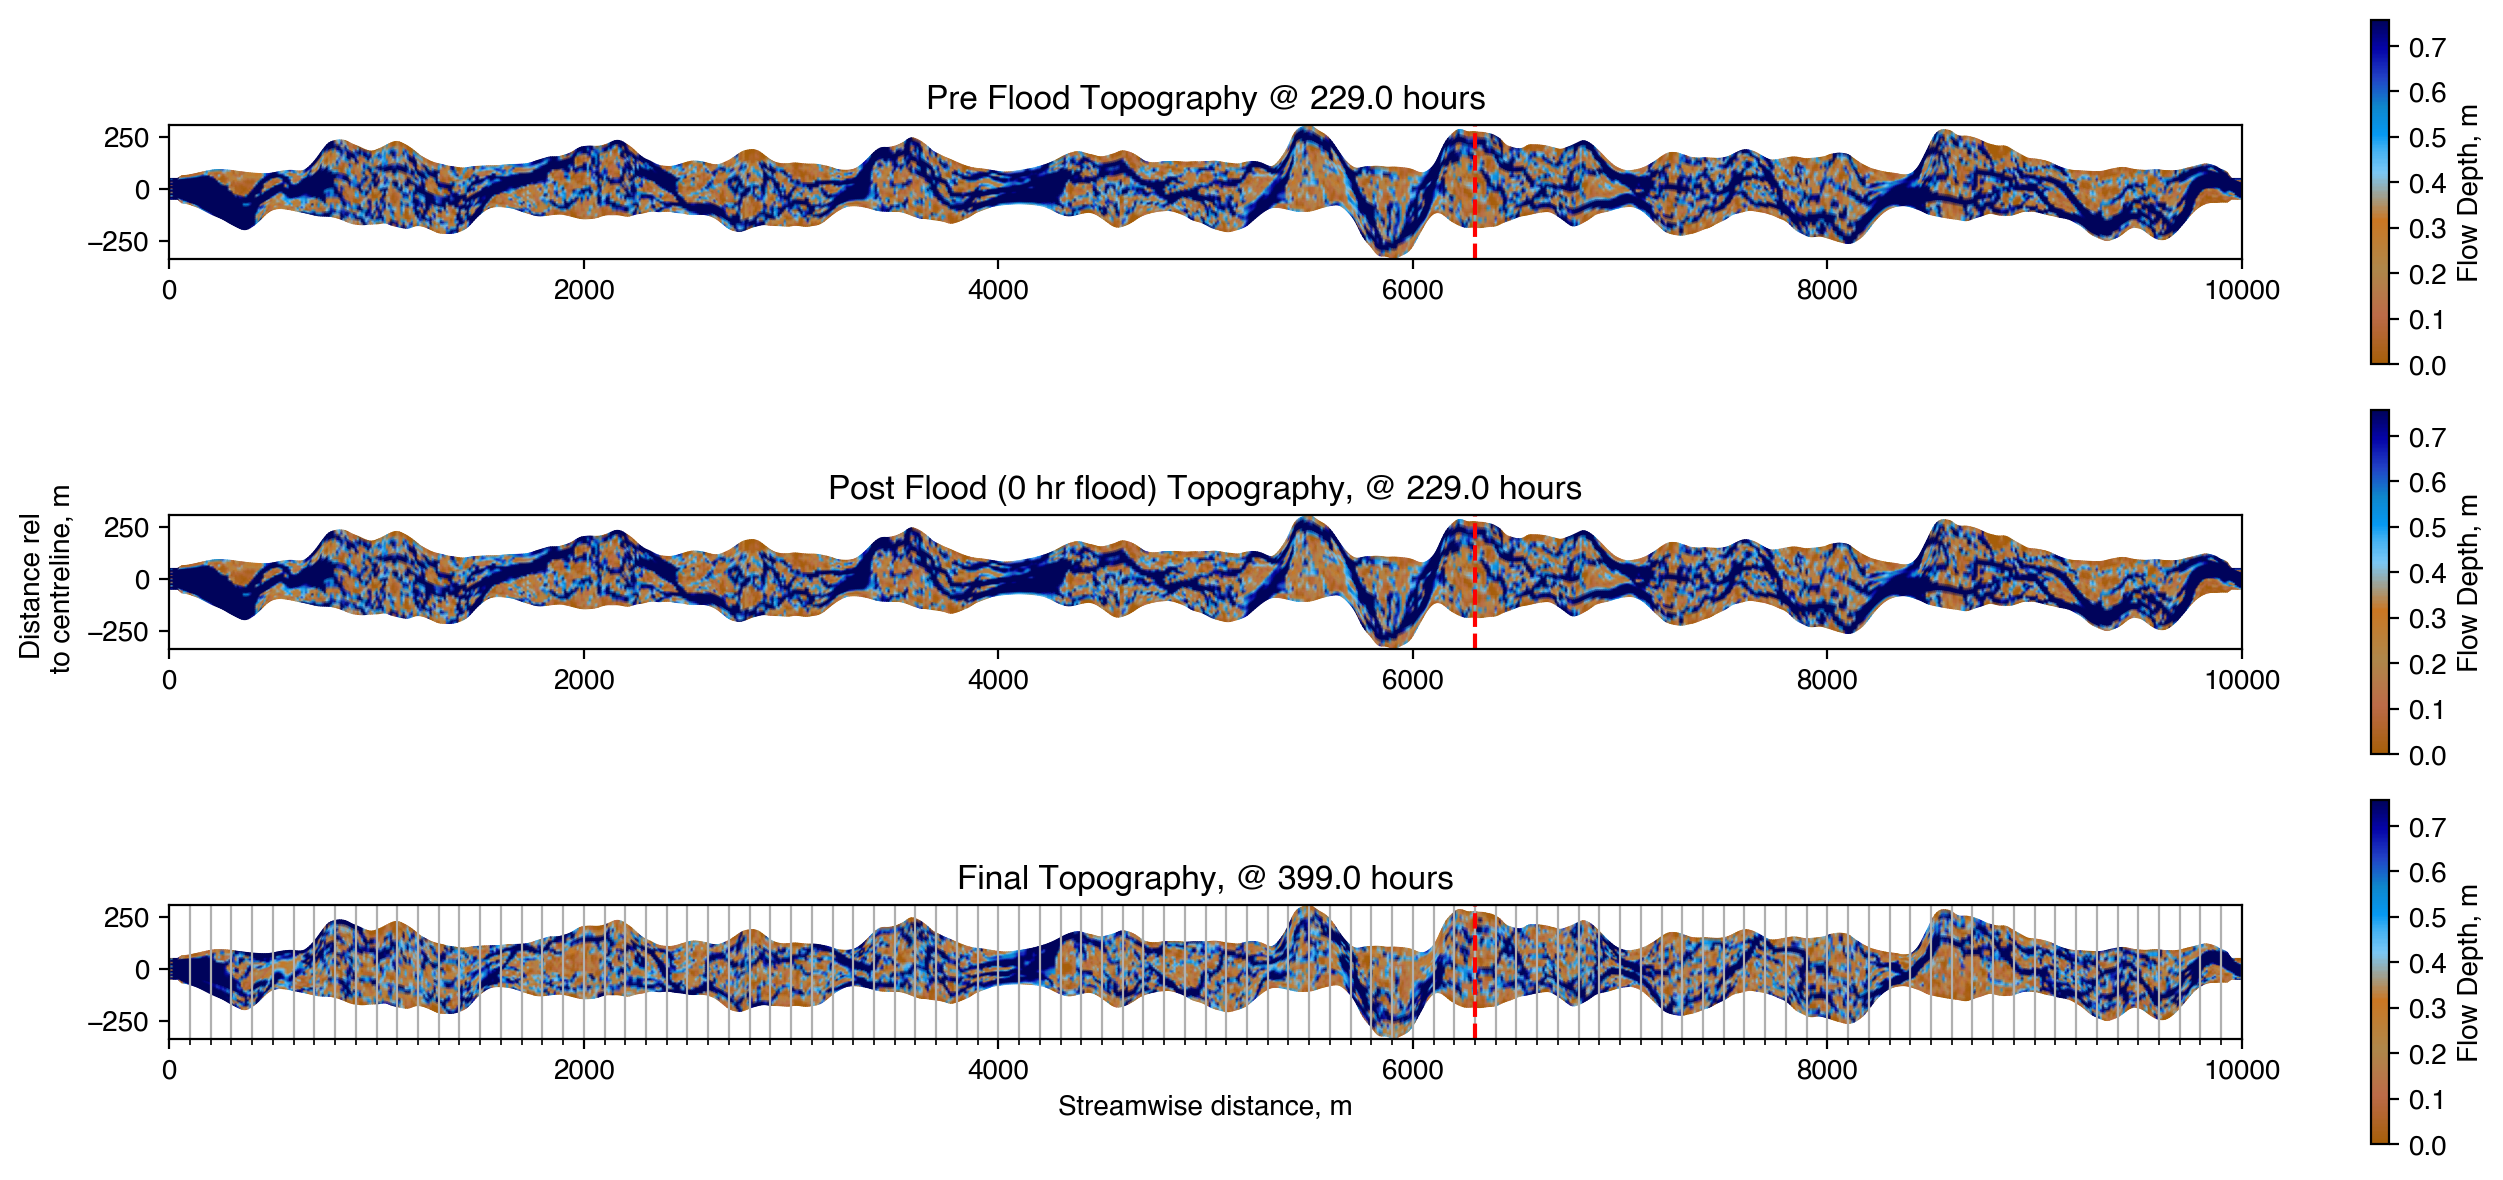

In [16]:
#create 2D grid
#extract elevation

xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
elev_final = np.reshape(datamaster[:, char, -1], (gridy, gridx)) ##using flow depth to plot
elev_pref = np.reshape(datamaster[:, char, pref_idx], (gridy, gridx)) ##using flow depth to plot
elev_postf = np.reshape(datamaster[:, char, post_idx], (gridy, gridx)) ##using flow depth to plot

llim = datamaster[:, char, :].min()
ulim = datamaster[:, char, :].max()

#find the max and min of the variable you're plotting to scale the colourmap
var_llim = datamaster[:, char, :].min() 
var_ulim = datamaster[:, char, :].max()
print(var_llim, var_ulim)

class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#normalise = plt.Normalize(-1, 2)
#midnorm = MidpointNormalize(vmin=-np.quantile(datamaster[:, 4, :], 0.1), vcenter=0.5, vmax=np.quantile(datamaster[:, 4, :], 0.99))
#midnorm = MidpointNormalize(vmin=0, vcenter=np.quantile(datamaster[:, char, :], .25), vmax=np.quantile(datamaster[:, char, :], .999)) 
midnorm = MidpointNormalize(vmin=0, vcenter=lowlim, vmax=toplim) 

fig, ax = plt.subplots(3, figsize = (14, 6), tight_layout = True, dpi = 200)
ax[1].set_ylabel('Distance rel \n to centreline, m')
ax[-1].set_xlabel('Streamwise distance, m')

ax[0].set_title(f'Pre Flood Topography @ {pref_idx*interval_to_plot} hours')
ax[1].set_title(f'Post Flood ({fldlength} hr flood) Topography, @ {post_idx*interval_to_plot} hours')
ax[-1].set_title(f'Final Topography, @ {end_t*interval_to_plot} hours')

ax[0].axvline(xsloc, c = 'r', ls = '--')
ax[1].axvline(xsloc, c = 'r', ls = '--')
ax[-1].axvline(xsloc, c = 'r', ls = '--')
dat_pref = ax[0].pcolormesh(xdomain, ydomain, elev_pref,cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
#dat_pref = ax[0].contourf(xdomain, ydomain, elev_pref,cmap = get_continuous_cmap(test), norm = midnorm, levels = 50)#, shading = 'gouraud', alpha = .8)
dat_postf = ax[1].pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)
dat_final = ax[-1].pcolormesh(xdomain, ydomain, elev_final, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = 1)

fig.colorbar(dat_pref, ax = ax[0], label = 'Flow Depth, m')
fig.colorbar(dat_postf, ax = ax[1], label = 'Flow Depth, m')
fig.colorbar(dat_final, ax = ax[-1], label = 'Flow Depth, m')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[-1].set_aspect('equal')
ax[-1].xaxis.set_minor_locator(MultipleLocator(100))
ax[-1].grid(axis = 'x', which = 'both')
#ax[0].set_xlim(500, 4500)
#ax[0].set_facecolor('xkcd:midnight blue')
#ax[1].set_facecolor('xkcd:midnight blue')
#ax[-1].set_facecolor('xkcd:midnight blue')
#plt.savefig(f'{savefilesto}planformchange/PF{modelrun}.png', dpi=100)

#plt.close(fig)

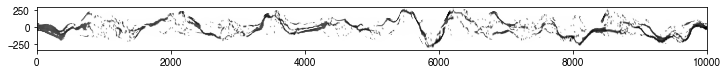

In [17]:
climu = np.quantile(attribs, 0.99) #upper centreline limit
climl = np.quantile(attribs, 0.75) #lower limits
climc = np.quantile(attribs, 0.45) #lower limits
cnorm = MidpointNormalize(vmin=climl, vcenter=climc, vmax=climu) 
fig, ax = plt.subplots(figsize = (12, 1))
ax.pcolormesh(xdomain, ydomain, elev_pref,cmap = get_continuous_cmap(centrelines), norm = cnorm, shading = 'gouraud', alpha = 1)
#ax.set_xlim(bhead*cellL, btail*cellL)
ax.set_aspect('equal')

## Plots to change over flood

In [18]:
fig, ax = plt.subplots(3, figsize = (15, 6), tight_layout = True)
floodtopochange = -1*(np.reshape(datamaster[:, 7, pref_idx], (gridy, gridx))-np.reshape(datamaster[:, 7, post_idx], (gridy, gridx)))
#diffnorm = MidpointNormalize(vmin = np.quantile(floodtopochange, 0), vcenter = 0, vmax = np.quantile(floodtopochange, 1))
diffnorm=MidpointNormalize(vmin = floodtopochange.min(), vcenter = 0, vmax = floodtopochange.max())
floodchange = ax[1].pcolormesh(xdomain, ydomain, floodtopochange, cmap = 'seismic_r', alpha = 1, norm = diffnorm, shading = 'gouraud')

fig.colorbar(floodchange, ax = ax[1], label = 'Change in Elev after flood, m')
#fig.colorbar(pre, ax = ax[0], label='Contours')
ax[1].set_ylabel('XSD, m')
ax[1].set_xlabel('Streamwise distance, m')
dat_postf = ax[-1].pcolormesh(xdomain, ydomain, elev_postf, cmap = get_continuous_cmap(test), norm = midnorm, shading = 'gouraud', alpha = .8)

fig.colorbar(dat_postf, ax = ax[-1], label = 'Flow Depth')
ax[0].set_title(f'Min Change = {floodtopochange.min()}, Max Change = {floodtopochange.max()}')
dis_flood = ax[0].hist(floodtopochange.ravel(), **kwargs)
ax[0].axvline(np.quantile(floodtopochange, 0.01), c='k', ls = '--')
ax[0].axvline(np.quantile(floodtopochange, 0.99), c='b', ls = '--')

ax[1].set_aspect('equal')
ax[-1].set_aspect('equal')
ax[1].axvline(xsloc, c = 'r', ls = '--')
ax[-1].axvline(xsloc, c = 'r', ls = '--')
plt.close(fig)

Crop and sort the data by jloc (removing ilocs that are not the desired section) so its in section order and not streamwise

In [19]:
#crop data
remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
data = np.delete(datamaster, remove_ilocs[0], axis=0)
print('Cropped, final dataset shape: ', data.shape)

#sort in cross stream direction from rightbank to left bank
#test = np.empty_like(datamaster)    
for i in range (0, num_timesteps):
    data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]
    #print(i, data[:, 3, i])


Cropped, final dataset shape:  (26, 11, 399)


Now fill in arrays for elevation, position, shear etc...

In [20]:
##Make the arrays to store data
stratigraphy = np.empty([end_t, cells]) ##will hold data for topography accounting for changes due to erosion
#print(elevation.shape) #elevation = np.empty([n, end_t])

print('Shape of prelim arrays: ', stratigraphy.shape)

#this matrix is to record unmodified stratigraphy in the same shape as the eroded strat
stratigraphy_idx = stratigraphy.copy()
#stratigraphy_idx[:] =  np.nan
#print(stratigraphy)

shearstresseroded = stratigraphy.copy() #will hold data for shear stress accounting for changes due to erosion
#shearstresseroded[:] = np.nan
#print('!!!', shearstresseroded.shape)

stratflowdepth =  stratigraphy.copy() #will hold data for flow depth accounting for changes due to erosion
#stratflowdepth[:] = np.nan

scaleflowdepth =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
#scaleflowdepth[:] = np.nan

froudedata =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
#froudedata[:] = np.nan

velocity =  stratigraphy.copy()
runtime = len(stratigraphy)
#print(runtime)
xposition =  stratigraphy.copy()

Shape of prelim arrays:  (399, 26)


In [21]:
in_section = np.where(datamaster[:, 0, -1]==iloc)
in_section = in_section[0]
bankpos = datamaster[:, 3, :][in_section]
#print(bankpos)
rightbank = bankpos.min() ##negativee
leftbank = bankpos.max() #positive
print('Left bank max position: ', leftbank)
print('Right bank max position: ', rightbank)

xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos
print('Shape of stratigraphy matrix:, ', xy_strat.shape)
xy_strat[:] = np.nan
ages = np.empty_like(xy_strat)

Left bank max position:  276.298444046
Right bank max position:  -184.552010926
Shape of stratigraphy matrix:,  (399, 464)


## Import, and fill the arrays that will be used for the rest of the code
1. Import data for shear stress, flow depth, velocity and froude
2. Interpolate data to represent actual channel dimensions and not grid dimensions
3. Fill and remove any remaining nans from the arrays

In [22]:
## Import the data
for time in range (0, data.shape[2]): #TIME
    #print(stratigraphy[time, :].shape)
    stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 5
    shearstresseroded[time, :] = data[:, 6, time] 
    stratflowdepth[time, :] = data[:, 4, time]
    froudedata[time, :] = data[:, 9, time]
    velocity[time, :] = data[:, 10, time]
    
    ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
    #print(ypos)
    xposition[time, :] = ypos

stratigraphy_idx = stratigraphy.copy()

##you need to change the y positions from centreline position to actual positional data
#print(xposition.max(axis = 1))

In [23]:
## these arrays will house interpolated data
shear = xy_strat.copy()
froude = xy_strat.copy()
scaleflow = xy_strat.copy() #flow depth scaled to max per time
trueflow = xy_strat.copy() #unscaled flow depth
flowvel = xy_strat.copy() #flow velocity

print('True shape, m: ', shear.shape, froude.shape, scaleflow.shape, trueflow.shape, flowvel.shape)

True shape, m:  (399, 464) (399, 464) (399, 464) (399, 464) (399, 464)


In [24]:
#put all data values in their correct x/index position
for t in range (0, end_t):
    #print(t)
    for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
        #print(x)
        #print(idx, x)
        x = int(np.floor(x)) #rounding down positions, making integers so can use as index
        #print(x, idx)
        xy_strat[t, x] = stratigraphy[t, idx]
        shear[t, x] = shearstresseroded[t, idx]
        froude[t, x] = froudedata[t, idx]
        trueflow[t, x] = stratflowdepth[t, idx]
        scaleflow[t, x] = scaleflowdepth[t, idx]
        flowvel[t, x] = velocity[t, idx]
    #plt.plot(xy_strat[t, :], '.')

In [25]:
xy_topo = np.empty_like(xy_strat)
xy_topo[:] = np.nan
for t in range (0, end_t):
    #print(t)
    length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
    pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
    #dataint = np.linspace(int(np.round(xposition[t, 0], 0)), int(np.round(xposition[t, -1], 0)), length, dtype=int) #range of locations to interpolate over?
    dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)
    #print(t, pos.max(), length)
    #print(len(dataint))
    #print(pos)
    
    stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
    shearnotnan = shear[t, :][~np.isnan(shear[t, :])] #pull out real values of shear
    froudenotnan = froude[t, :][~np.isnan(froude[t, :])] #pull out real values of froude
    truefnotnan = trueflow[t, :][~np.isnan(trueflow[t, :])] #pull out real values of true flow depth
    #scalefnotnan = scaleflow[t, :][~np.isnan(scaleflow[t, :])] #pull out real values of scaled flow depth
    velnotnan = flowvel[t, :][~np.isnan(flowvel[t, :])] #pull out real values of strat
    #print(shear[t, :][~np.isnan(shear[t, :])])
    #print(shearnotnan[:].shape, froudenotnan[:].shape, truefnotnan[:].shape, velnotnan[:].shape)
    #print(xposition[t, :])
    #print(dataint)
    fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
    #print(fx)
    fsh = interpolate.interp1d(xposition[t, :], shearnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #shear stress interpolation
    ffr = interpolate.interp1d(xposition[t, :], froudenotnan[:], kind = 'cubic', fill_value = 'extrapolate') #froude number interpolation
    ftf = interpolate.interp1d(xposition[t, :], truefnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #true flow depth interpolation
    #fsf = interpolate.interp1d(xposition[t, :], scalefnotnan[:], kind = 'cubic') #scaled flow depth interpolation
    ffv = interpolate.interp1d(xposition[t, :], velnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
    
    #print(fx(dataint))
    
    xy_topo[t, dataint] = fx(dataint) #reassign strat
    #print(xy_topo[t, :])
    shear[t, dataint] = fsh(dataint) #reassign shear
    froude[t, dataint] = ffr(dataint) #reassign froude
    trueflow[t, dataint] = ftf(dataint) #reassign true fd
    #scaleflow[t, 0:length] = fsf(pos) #reassign scaled fd
    flowvel[t, dataint] = ffv(dataint) #reassign flow vel
    
    #plt.plot(xy_topo[t, :])
#plt.ylim(-3, 3)

Now I have an array with one column of cross-stream distance data and n columns of elevation data...now we plot. 
Because we are eroding to the position it was before then the shear stress must also be what it was before, therefore we can do thge same thing with stratgiraphy.

In [26]:
#each of these conditional arrays have a border of nans to helo pick out the 'packages'
posnew = np.arange(0, xy_topo.shape[1])

stratcondition = np.zeros_like(xy_topo)
stratcondition[:] = np.nan


erosurf = np.empty([end_t, xy_topo.shape[1]])
erosurf[:] = np.nan


In [27]:
strat = copy.deepcopy(xy_topo)
for time in range (0, end_t):
    #plt.plot(stratigraphy[time]) #this is just a check to make sure youre importing the data correctly
    
    #now we have stratigraphy at each timestep with time on the j axis and position on the i
    #we want to check each location at each timestep for areas that have erodible elevation (i.e. higher than current timestep)
    
    for space in range (0, xy_topo.shape[1]):
        #print(space)
        preexisting_strata = xy_topo[:time, :] #this is our search array, where we will erode
        #preexisting_strata_idx = stratigraphy_idx[:time, :]
        
        #print(preexisting_strata.shape)
        #print('xy', xy_strat[time, :].shape)
        willerode = np.where(preexisting_strata[:, space] > xy_topo[time, space])
        #print('willerode', willerode)
        
        #print(time, column, willerode)
        
        xy_topo[willerode, space] = xy_topo[time, space]
        ages[willerode, space] = time
        #stratigraphy_idx[willerode_idx, column] == np.nan
    #print(stratigraphy_idx[time])
    

#plt.ylim(0.1, 4)
    #print('st', stratigraphy)
#print('sh', shearstresseroded)
#print(ages[:5])
## fill an areas with data 'above it' in the section

for i in range (end_t-2, -1, -1):
    
    fillinx = np.where(np.isnan(xy_topo[i, :]))
    xy_topo[i, fillinx] = xy_topo[i+1, fillinx]
    #strat[i, fillinx] = strat[i+1, fillinx]
    ## fill in all filled in areas in the strat condition matrix with the flag for erosion
    stratcondition[i, fillinx] = 1
    #print(stratcondition[i, fillinx])
    
    fillinsh = np.where(np.isnan(shear[i, :]))
    shear[i, fillinsh] = shear[i+1, fillinsh]
    
    fillinfr = np.where(np.isnan(froude[i, :]))
    froude[i, fillinfr] = froude[i+1, fillinfr]
    
    fillintf = np.where(np.isnan(trueflow[i, :]))
    trueflow[i, fillintf] = trueflow[i+1, fillintf]
    
    fillinsf = np.where(np.isnan(scaleflow[i, :]))
    scaleflow[i, fillinsf] = scaleflow[i+1, fillinsf]
    
    fillinfv = np.where(np.isnan(flowvel[i, :]))
    flowvel[i, fillinfv] = flowvel[i+1, fillinfv]
    
    fillinstrat = np.where(np.isnan(strat[i, :]))
    #strat[i, fillinstrat] = strat[i+1, fillinstrat]
    
    #print('no fill', xy_topo[i, fillin])
    
    #print('fill', xy_topo[i, fillin])

*Verify that the stratigraphy looks the way it should*

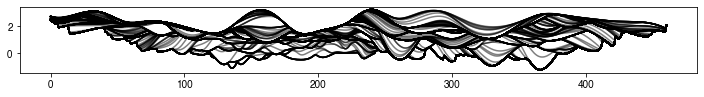

In [28]:
fig, ax = plt.subplots(figsize = (10, 10), tight_layout=True)
for i in range(0, end_t):
    ax.plot(xy_topo[i, :], 'k', alpha = 0.5)
ax.set_aspect(10)

In [29]:
def rounddown(num_timesteps, lineint):
    return num_timesteps - (num_timesteps%lineint)

## Declare maximum flow depth for scaling

In [30]:
maxflow = np.reshape(np.nanmax(trueflow, axis=1), [end_t, 1])
scaleflow = trueflow/maxflow

In [31]:
print('Maximum flow depth: ', maxflow.max())
fig, ax = plt.subplots(1, 2, figsize= (14, 6), tight_layout = True)
ax[0].hist(stratflowdepth.ravel(), **kwargs)
flowdep = np.mean(stratflowdepth)

for i in range (0, end_t):
    ax[1].plot(i, stratflowdepth[i, :].min(), marker = 'v', ms = '2', mec = 'xkcd:grey', mfc = 'r')
    ax[1].plot(i, stratflowdepth[i, :].max(), marker = '^', ms = '2', mec = 'b', mfc = 'b')
    ax[1].plot(i, np.mean(stratflowdepth[i, :]), marker = '.', ms = '5', mec = 'k', mfc = 'k')
    
ax[1].set_title('Time Series of Flow Depth at XS\n blue = max, grey = min, black = mean') 
ax[0].set_title('Distribution of flow depth at section')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Flow Depth, m')

ax[1].set_ylabel('Flow Depth, m')
ax[1].set_xlabel('Timestep, 2hours')

ax[1].axvline(fldstart, c='r', ls = '--');
ax[1].axvline(fldstart+(fldlength/interval_to_plot), c='r', ls = '--');

plt.close(fig)

Maximum flow depth:  3.829291777321103


###### Set up the grids for plotting

In [32]:
start_time = 0 #would be start of model run
end_time = end_t #would be end of model run

tim = range(start_time,end_time) #range of time

position = np.arange(0, xy_topo.shape[1], dtype = float)

## Define formulae:

<b>Calulating moving gravient along the stratigraphy </b> this shit dont work, take t from an old code


gradientdata = np.empty_like(xy_topo)
def movinggrad(yax, xax, ydata, xdata): #want a function to create a matrix of the gradient between two grid cells across domain
    
    gradmatrix = np.empty([yax, xax]) #matrix will look like plot axes so yax = rows = strat data, xax = cols
    print(gradmatrix.shape)
    for row in range (0, ydata.shape[0]):
      print(row)
      for k in range (0, xax):
        print(k)
        if ydata.shape[0]<=1:
          gradmatrix[k] = (ydata[k+1]-ydata[k])/(xdata[k+1]-xdata[k])
        else:  
          gradmatrix[row, k] = (ydata[row, k+1]-ydata[row, k])/(xdata[k+1]-xdata[k])
    return gradmatrix   
    #print(gradmatrix)
    #gradientdata[:] = gradmatrix[:]
    #print('gradients', gradientdata)
    #gradientdata[:] = np.degrees(np.arctan(gradientdata[:]))
    #print('angles', gradientdata)
    #print(gradmatrix)

In [33]:
def movinggrad(stratarray, posarray):
    ## find the moving gradient of the surfaces at 1m intervals
    ##stratarray = array with final stratigraphy, posarray = array with xposition in m
    #create gradmatrix
    
    gradmatrix = np.zeros_like(stratarray)

    for t in range (0, stratarray.shape[0]): #for each timestep in the matrix
        for x in range (0, stratarray.shape[1]-1): #for each x position, have to stop before 1 to work with array dims
            gradmatrix[t, x] = (stratarray[t, x+1]-stratarray[t, x])/(posarray[x+1]-posarray[x])
            
    return gradmatrix

In [34]:
strat_gradient = movinggrad(xy_topo, posnew)

<b> Calculating the shear stress boundaries from the model data </b>

Calculating thresholds to predict bedforms from shear stress a la Baas et al., 2015

Assuming a quartz mineralogy

D50 (Limaye) = 0.42mm
D50 (North Loup) = 0.31mm

For medium sand: 
    psi = 2 – 1	
    D50 = 0.25 – 0.5	
    Dimensionless Shield's Parameter = 0.048 – 0.033	
    Critical bed shear stress (N/m2) = 0.194 – 0.27

https://pubs.usgs.gov/sir/2008/5093/table7.html


From Baas et al, T = excess bed shear stress parameter:

T = (τb - τb, cr)/τb, cr
<br> where: τb = bed shear stress based on skin friction instead of form drag and τb, cr = critical bed shear stress for sediment movement
    
<br>D* = [g((ρs/ρ)-1)/(ν^2)]^1/3 * D50
<br>where g = gravity, ρs = sediment density, ρ = fluid density, ν = kinematic viscosity of water (1.787*10-6 m2/s)



In [35]:
#Tdunes = 17
#Tanti = 25 #assuming transition is maximum threshold for dune vs higher order bedform for uniform 
#Tmripples = 12 # T for megaripples & dunes
#Trippleslow = 3 #T for miniripples
if d50 == 0.31e-3:
    Tarray = [0, 0.07, 0.3, 0.6, 1, 10]
    #Tanti = 1
    #Tdunes = 0.3
    #Twashdun = 0.6
    #Tripples = 0.07 #using the mobility parameter graph

elif d50 == 1e-3:
    Tarray = [0, 0.05, 0.07, 0.4, 1, 10]
    
else: 
    print("CHECK GRAIN SIZE!!")
tb = p*g*slope*flowdep #shear stress on bed usng mean flow depth of entire run
tbcr = tb/((ps-p)*g*d50)  #critical bed shear stress for sediment movement
partsize = np.power((g*((ps/p)-1))/(nu**2), (1/3))*d50 #for medium sand

V_facies = [0, 0.55, 1.1, 1.85, 10] #if we are using velocity and grain size to compute bedofrm stability
print("Particle size parameter: ", partsize)
print("Critical bed shear stress for sediment mvt: ", tbcr)
print('Mean flow depth: ', flowdep)


Particle size parameter:  7.574918331981756
Critical bed shear stress for sediment mvt:  1.8411891278794503
Mean flow depth:  0.6874220721973278


<b>Define formula for calculating centroid </b>

Calculated as mean x mean y. Requires x y data in :, 2 shape

In [36]:
def centroidpython(data):
    x, y = zip(*data)
    l = len(x)
    return sum(x) / l, sum(y) / l

<b> To find ideal number of bins for histogram using Sturges rule: n = 1 + 3.22 log (n) </b>

This really is only for normal data, but whatever, otherwise, declare your own nbins


In [37]:
def roundup(number, upto):
    rounded = round(number/upto)*upto
    return rounded

## Plot of stratigraphy only

Set up plotting cmaps

In [38]:
# Make a user-defined colormap.
cm1 = mycmap
cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))

# Turn these into an object that can be used to map time values to colors and can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=timesteps_r) 
cpick.set_array([])

## Plot the froude and WSE profile of the run (if in streamwise direction)

In [39]:
if datacond == 2: 
    fig, ax1 = plt.subplots(figsize = (19.2, 6.80))
    water = ax1.plot(wse[:, 0], wse[:, -1], 'b', lw = '2', label = 'Water Surface Elevation')
    bed = ax1. plot(elevation[:, 0], elevation[:, -1], 'k', lw = '2', label = 'Bed Elevation')
    
    ax2 = ax1.twinx()
    fr = ax2.plot(froudenumber[:, 0], froudenumber[:, -1], 'r', lw = '1', label = 'Froude Number')
    ax2.plot([0, elevation[-1, 0]], [1, 1], 'k--', lw = '1', alpha = 0.5)
    
    ax1.set_ylabel('Elevation, (m)', color = 'b')
    ax1.tick_params(axis = 'y', labelcolor = 'b')
    ax1.set_xlabel('Downstream Distance, (m)')
    
    ax2.tick_params(axis = 'y', labelcolor = 'r')
    ax2.set_ylabel('Froude Number', color = 'r')
    
    lns = water + bed + fr
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, loc=0)
    plt.title('Bed Conditions at end of run')
    plt.savefig(savefilesto+modelrun+'bedcond' + '.png', format='png', dpi = 1200)

## Declaring what the threshold for a hiatal surface is

In [40]:
ages_ero = np.empty_like(xy_topo)


In [41]:
## SCENARIO 1: Hiatus = any elevation change that is less than x cm

## SCENARIO 2: Hiatus = any elevation change that is less than x % of the average elevation change

## SCENARIO 3: Hiatus = any elevation change that is less than the xth percentile of change at the timestep
hiatal_scenario = 2

threshold_thick = 0.005  #absolute value in metres 

nth = 25 #what percentile distribution to use to calculate hiatal surfaces for each timestep
perc = 0.1 #fraction of percentile

### Now we are defining the ages of each surface 

In [42]:
#print(len(posnew))
for time in range (1, end_t):
    #print(time)
    ages_ero[time, :] = time 
    #stratinterpcub[time, :] = topointerp[time, :]
    
    lessthan = np.where(strat[time, :] < xy_topo[time-1, :])
    ele_change = strat[time, :]-xy_topo[time-1, :] #find the bed elevation change across the domain
                                                                   #it has to be before you reassign topography else 
                                                                   #you will get zeros where replaced
    #print(ele_change)
    #for space in range (0, ages_ero.shape[1]):
        
        #preexisting_strata_int = stratinterpcub[:time, :] #this is our search array, where we will erode
        
    #willerode_int = np.where(ele_change < 0)
    #print(willerode_int)
        #stratinterpcub[willerode_int, space] = stratinterpcub[time, space] #tune the stratigraphy for erosion
        
    ages_ero[time, lessthan] = ages_ero[time-1, lessthan]
        
    
    if hiatal_scenario == 1:
        threshold_thick = perc*(np.mean(ele_change)) #find the fraction of the average elevation change between the two latest timesteps
    
    if hiatal_scenario == 2:
        threshold_thick = perc*np.percentile(ele_change, nth)
    
    if time != 0:
        hiatus_idx = np.where(abs(ele_change) < abs(threshold_thick))
    #print(time, hiatus_idx)
    #print('change', ele_change)
    #print(time, hiatalrange, hiatus_idx)
    #print(time, np.mean(ele_change), hiatalrange)
        ages_ero[time, hiatus_idx] = ages_ero[time-1, hiatus_idx]
ages_ero[-1, :] = end_t
        #print(ages_ero)

### Now we construct the conditions of deposition, hiatus or erosion

This might be something to come back to becuase I currently do not have a working, transferrable definition of a hiatal surface, but for shits and giggles sake, since we are working with a field scale simulation and we expect m scale bars, lets say that a hiatal surface is a surface that aggrades less than 1mm ~ 0.1% of the elevation of the bar i.e. 0.99 x topo ≤ topo[t] ≤ 1.01 x topo[t-1]

Let's define erosion where topo[t] < 0.99 x topo[t]

Lets define deposition where topo[t] > 1.01 x topo[t-1]

Then we will make an array that houses the condition of the surfaces only (stratcondition) defined by whether the subsequent surface is eroding, depositing or non-depositing sediment 

##### Making the arrays that store erosion, hiatal, deposition and erosional and hiatal surfaces

In [43]:
#these will all be filled with nans
deposurf = erosurf.copy()
hiatalsurf = erosurf.copy()
erohiatalsurf = erosurf.copy()
time_of_ero = erosurf.copy()

### Create stratcondition (0, 1, 2 for depo, ero, hiatal) and surface arrays with nans and topo of ero/depo/hiatal surfaces

In [44]:
#stratcondition = np.zeros_like(xy_topo)
#print(stratcondition.shape)

thickness = np.zeros_like(xy_topo)
#print(thickness.shape)

#erosurf[stratcondition==1] = xy_topo[stratcondition==1]

#hiatal_prop = 0.1 #multiple for proportion of thickness change defining a hiatal surface (decimal) 
                #i.e. a surface is hiatal if its elevation changes by less than 10% (of the percentile or average)

#stratcondition[0, :] = 0

fig, ax = plt.subplots(2, 3, figsize = (19.80, 10.8), tight_layout = True)#, sharey = True, sharex = True)#, sharex = True, sharey = True)

for time in range (1, end_t):
    
    
    #ax[0,0].plot(posnew, topointerp[time], color=cpick.to_rgba(time))
    thickness[time, :] = strat[time, :]-strat[time-1, :]
    thickness[time, :][np.isnan(thickness[time, :])] = 0
    #print(thickness[time, :])
    ax[0,1].plot(time, thickness[time, :].max(), marker = 'o', mew = 0, markerfacecolor = 'xkcd:cobalt blue')
    ax[0,1].plot(time, thickness[time, :].min(), marker = 'o', mew = 0, markerfacecolor = 'xkcd:green yellow')
    ax[0,1].plot(time, np.average(thickness[time, :]), marker = 'o', mew = 0, markerfacecolor = 'xkcd:coral')
    #print(thickness[time, :].max(), thickness[time, :].min(), np.average(thickness[time, :]))
    #print(thickness[thickness>0])
    #ax[0, 1].set_xlim(0, end_t)
    #ax[0, 1].set_ylim(-1, 1)
    if hiatal_scenario == 1:
            #using a percentage of the average thickness to constrain hiatal surfaces
        threshold_thick = perc*(np.mean(thickness[time, :]))  #x% of the average sediment thickness at x time. may be negative.
    elif hiatal_scenario == 2:
            #using nth percentile of the thicknesses at each timestep
        threshold_thick = perc*np.percentile(abs(thickness[time, :]), nth) #find the nth percentile of depositon at x time. positive number.
    
    ax[0,0].plot(time, threshold_thick, 'o', markerfacecolor = cpick.to_rgba(time), markeredgecolor = cpick.to_rgba(time), linewidth = 0.0001, markersize = 14, alpha = 0.5)
    
    
    ax[0,0].set_ylim(-0.05, .05)
    #print('10th', np.percentile(abs(thickness), nth), 'thresh', threshold_thick)
    
    hiatalwhere = np.where(abs(thickness[time, :]) < threshold_thick) #where elev change is less than 10% avg
    depositingwhere = np.where(thickness[time, :] > threshold_thick)
    erodingwhere = np.where(thickness[time, :] < -abs(threshold_thick))
    #print(time, depositing where)
    
    
    #print(time, 'hiatus', hiatalwhere)
    #print('hdata', thickness[hiatalwhere])
    #print(time, 'ero', erodingwhere)
    #print('edata', thickness[thickness<0])
    
    #print(time, stratcondition[time, :])
    
    stratcondition[time, depositingwhere] = 0
    stratcondition[time, erodingwhere] = 1
    stratcondition[time, hiatalwhere] = 2
    erodereset = np.where(stratcondition[time, :]==1)
   
    #print(erodingwhere, erodereset)
    #print(stratcondition[time, :])
    #print(erodereset)
    #erosurf[time, erodingwhere] = xy_topo[time, erodingwhere]
    erosurf[time, erodereset] = xy_topo[time, erodereset]
    deposurf[time, depositingwhere] = xy_topo[time, depositingwhere]
    hiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    erohiatalsurf[time, erodereset] = xy_topo[time, erodereset]
    erohiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    #print('surf', erosurf[time, 220:])
    
    ax[1,0].plot(erosurf[time], color=cpick.to_rgba(time))
    ax[1,1].plot(hiatalsurf[time], color=cpick.to_rgba(time))
    ax[0, 2].plot(deposurf[time], color=cpick.to_rgba(time))
    #ax[1, 2].plot(posnew, erohiatalsurf[time], color=cpick.to_rgba(time))
    ax[1, 2].plot(erosurf[time], 'r')
    ax[1, 2].plot(hiatalsurf[time], 'g')
#erohiatalsurf[-1, :] = xy_topo[-1, :]

#ax[1, 3].hist(percentile)
#ax[0, 3].hist(abs(thickness).flatten())
#ax[0, 3].axvline(x=np.percentile(abs(thickness), 1), c = 'r')   
ax[0,0].title.set_text('Time Series of Threshold thickness vals')
ax[0,1].title.set_text('time seties of bed elevation changes')
ax[0,2].title.set_text('Depositional Surfaces Only')
ax[1,0].title.set_text('Erosion Surfaces Only')
ax[1,1].title.set_text('Hiatal Surfaces Only')
ax[1,2].title.set_text('Erosional and Hiatal Surfaces')
#ax[0, 3].title.set_text('Distribution of ALL thicknesses, red line = '+str(nth)+'th Percentile')
#ax[1, 3].title.set_text('Distribution of ALL percentiles/timestep')

ax[0, 1].legend()
ax[0,0].set_facecolor('xkcd:grey') 
ax[0,1].set_facecolor('xkcd:grey') 
ax[0,2].set_facecolor('xkcd:grey') 
ax[1,0].set_facecolor('xkcd:grey') 
ax[1,1].set_facecolor('xkcd:grey') 
ax[1,2].set_facecolor('xkcd:grey') 
#print(thickness[3, :])
#print(stratcondition)#[3, :])
#np.where(stratcondition == 1)

#plt.savefig(savefilesto+'surf_creation/'+modelrun+'testforhiat.png', format='png', dpi = 200)
plt.close(fig)

No handles with labels found to put in legend.


## Look at histogram of thickness changes in entire stratigraphy

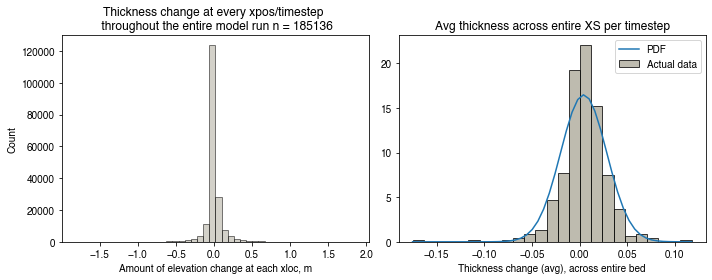

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)
hist = ax[0].hist(thickness.ravel(), bins = 50, ec = 'k', fc = 'xkcd:greyish', alpha = 0.5)
ax[0].set_xlim(thickness.min(), thickness.max())
thickavg = np.average(thickness, axis = 1)
loc = np.average(thickavg)
scale = np.std(thickavg)
x = np.linspace(thickavg.min(), thickavg.max())
y = stats.norm.pdf(x, loc, scale)

ax[1].plot(x, y, label = 'PDF')
ax[0].set_xlabel('Amount of elevation change at each xloc, m')
ax[0].set_ylabel('Count')
ax[0].set_title('Thickness change at every xpos/timestep \n throughout the entire model run n = '+str(len(thickness.ravel())))
#ax[0].set_xlim(-0.1, 0.1)

avghist = ax[1].hist(thickavg, bins = 25, ec = 'k', fc = 'xkcd:greyish', alpha = 0.75, density = True, label = 'Actual data')
ax[1].set_title('Avg thickness across entire XS per timestep')
ax[1].set_xlabel('Thickness change (avg), across entire bed')
ax[1].legend()
#plt.savefig(savefilesto+'stats/'+modelrun+'erodephist.png', dpi = 100)


## so we have the ages of the stratigraphy
technically an erosion surface will be all the same age? 

Sambrook smith et al, 2019 did a similar thing where they found the main topographic surfaces by collecting the topography that connects the erosional points

I'm going to try to do that somehow

ages_ero is the age of all the erosion surfaces
erosurf houses all the erosional surfaces in their space time structure
if we find age at erosurf and plot stratinterbcub at that time then we might have done it????

## Plot Stratigraphy with erosurfaces and hiatals colourised

5.131312051831718


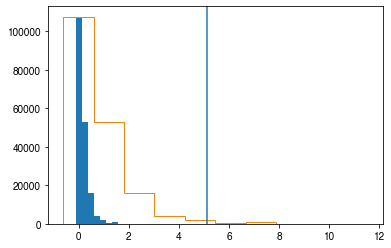

In [46]:
## assuming bed shear stress output from nays is skin friction not form drag, 
# calculate mobility parameter and particle size parameter to predict facies
#Tparam = (shearstresscub-tbcr)/tbcr #using the excess bed shear stress parameter
Tparam = shear/(g*(ps-p)*d50)#using the mobility parameter
plt.hist(Tparam.ravel());
plt.hist(shear.ravel(), histtype = 'step');
plt.axvline(np.nanquantile(shear, 0.99))
print(np.nanquantile(shear, 0.99))
#plt.hist(bedshear_crit.ravel(), fc='r')
#plt.hist(bedshear_vel.ravel())

## four subplots only (elev, depth, shear, velocity)

(-1.2337625783403579, 3.2674536382160193)

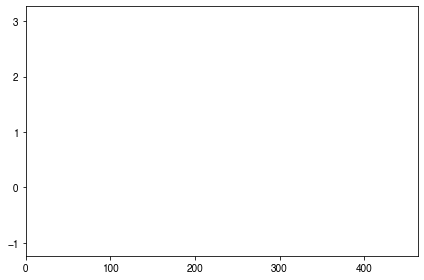

In [47]:
fig, ax = plt.subplots(1, tight_layout = True)
for t in range (0, end_t):
    slope = strat_gradient[t]
    zdata = xy_topo[t]
    
    points = np.array([posnew, zdata]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    slopenorm = plt.Normalize(strat_gradient.min(), strat_gradient.max())
    
    slopelc = LineCollection(segments, cmap = 'RdBu', norm = slopenorm)
    slopelc.set_array(slope)
    slopelc.set_linewidth(3)
    slopeline = ax.add_collection(slopelc)
    
ax.set_xlim(posnew.min(), posnew.max())
ax.set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo))

In [45]:
start_time = 0 #would be start of model run
end_time_int = num_timesteps-1 #would be end of model run

tim_int = range(start_time,end_time) #range of time
xdat_int = posnew #position
ydat_int = [xy_topo[t] for t in tim_int] #stratigraphy/elevation @ position

cmap_fac = ListedColormap(['xkcd:mud brown', 'xkcd:dirt', 'xkcd:sandy brown', 'xkcd:beige', 'xkcd:stone'])
norm_fac = BoundaryNorm(Tarray, cmap_fac.N)

cmap_velfac = ListedColormap(['xkcd:dirt', 'xkcd:sandy brown', 'xkcd:beige', 'xkcd:stone'])
norm_velfac = BoundaryNorm(V_facies, cmap_velfac.N)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, sharey=True, squeeze = True, tight_layout=True, figsize=(8, 8), dpi = 200)

#for y, t in zip(ydat_int,tim_int):
#    stratig = ax1.plot(xdat_int,y,color=cpick.to_rgba(t), lw = 3, alpha = 1)

#fig.colorbar(cpick,label="Time", ax=ax1)
np.array([posnew, elevint]).T.reshape(-1, 1, 2)
for strata in range (0, end_t):
    
    ax1.set_xlim((posnew.min(), posnew.max())) #braided test
    #ax1.set_xlim((4000, 5000))
    #ax1.set_ylim((-2.5, 2.5))
    ax1.set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo)) #braided test

    ########### PULL THE DATA OUT FOR EACH TIMESTEP
    
    elevint = xy_topo[strata]
    shearstressint = shear[strata]
    depthint = scaleflow[strata]
    actualdepth = trueflow[strata] #we do not want scaled flow depth for the facies
    #froudenumint = froudecub[strata]
    #slopeint = gradcub[strata]
    #froudenum[0] = is.nan
    velint = flowvel[strata]
    transportstage = Tparam[strata]
 
    pointsint = np.array([posnew, elevint]).T.reshape(-1, 1, 2)
    segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)

    ########### SET UP THE NORMALISATION

    sheargradint = plt.Normalize(np.nanmin(shear), np.nanmax(shear)) #bed shear based on skin friction for anti dunes = 4.410)
    depthgradint = plt.Normalize(np.nanmin(actualdepth), np.nanmax(actualdepth))
    depth_quant = plt.Normalize(np.nanmin(depthint), np.nanquantile(trueflow, 0.95))
    velogradint = plt.Normalize(np.nanmin(velint), np.nanmax(velint)) ##gradient plot for flow velocity
    acdepth = plt.Normalize(np.nanmin(actualdepth), np.nanmax(actualdepth)) #normalistion with the aactual flow depth
    shear_quant = plt.Normalize(np.nanmin(shear), np.nanquantile(shear, 0.99)) #normalising ot shear stress max 99th ptile bc 10 is too high
    #transport = plt.Normalize(np.nanmin(transportstage), np.nanmax(transportstage)) ##gradient plot for flow velocity
    
  

  ########### MAKE THE LINE COLLECTIONS ###########
    
    #-------- SHEAR STRESS
    gradlcint = LineCollection(segmentsint, cmap=plt.get_cmap(ss_facies_r), norm=shear_quant)
    #gradlcint = LineCollection(segmentsint, cmap=cmap, norm=normbd)
    
    gradlcint.set_array(shearstressint)
    gradlcint.set_linewidth(3)
    gradlineint = ax3.add_collection(gradlcint)

    #-------- SCALED FLOW DEPTH
    depthlcint = LineCollection(segmentsint, cmap=plt.get_cmap(depths), norm=depthgradint)
    depthlcint.set_array(depthint)
    depthlcint.set_linewidth(3)
    
    depthlineint = ax2.add_collection(depthlcint)
   
    #-------- DOUBLE PLOT OF VELOCITY/FLOW DEPTH AND SHEAR STRESS
#    vel_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(redyellow), norm=velogradint)
    vel_mix = LineCollection(segmentsint, cmap='Reds', norm=velogradint)
    vel_mix.set_array(velint)
    vel_mix.set_linewidth(3)
    
#    shear_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(yellowblue), norm=shear_quant)
#     shear_mix = LineCollection(segmentsint, cmap='Blues', norm=shear_quant)
#     shear_mix.set_array(shearstressint)
#     shear_mix.set_alpha(0.7)
    
#     depth_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(redyellow), norm=depth_quant)
#     depth_mix.set_array(depthint)
#     depth_mix.set_alpha(0.5)
    
#    shear_mix_line = ax1.add_collection(shear_mix)
    #depth_mix_line = ax1.add_collection(depth_mix)
    vel_mix_line = ax1.add_collection(vel_mix)
    #-------- FROUDE NUMBER
    #froudegradint = plt.Normalize(froudenumint.min(), froudenumint.max())
    
    #froudelcint = LineCollection(segmentsint, cmap=plt.get_cmap('seismic'), norm=froudegradint)
    #froudelcint.set_array(froudenumint)
    #froudelcint.set_linewidth(2.5)
    
    #froudelineint = ax4.add_collection(froudelcint)

    #-------- VELOCITY    
    
    #velolcint = LineCollection(segmentsint, cmap = cmap_fac, norm = normbd)
    #velolcint.set_array(velint)
    #velolcint.set_linewidth(3)
    
    #-------- MOBILITY PARAMETER (FACIES)
        
    #transportlc = LineCollection(segmentsint, cmap = cmap_fac, norm = norm_fac)
    #transportlc.set_array(transportstage)
    #transportlc.set_linewidth(2)
    #transportline = ax4.add_collection(transportlc)
    
    #-------- MOBILITY WITH VELOCITY NOT SHEAR
    velofacies = LineCollection(segmentsint, cmap = cmap_velfac, norm = norm_velfac)
    velofacies.set_array(velint)
    velofacies.set_linewidth(3)
    velofacies_line = ax4.add_collection(velofacies)
    

    
ax1.set_facecolor('xkcd:grey')
ax2.set_facecolor('xkcd:grey')
ax3.set_facecolor('xkcd:grey')
ax4.set_facecolor('xkcd:midnight blue')

ax4.set_xlabel('Cross stream distance, m')

ax1.set_ylabel('Bed Elevation, m')
ax2.set_ylabel('Bed Elevation, m')
ax3.set_ylabel('Bed Elevation, m')
ax4.set_ylabel('Bed Elevation, m')

#fig.colorbar(shear_mix_line, label = 'SS', ax=ax1)
fig.colorbar(vel_mix_line, label = 'Vel', ax=ax1)
fig.colorbar(gradlineint, label = "Shear Stress, N/m$^2$", ax=ax3)
fig.colorbar(depthlineint, ax=ax2, label = 'Flow Depth')
fig.colorbar(velofacies_line, ax=ax4, label = 'Flow Velocity')

ax1.title.set_text(f'Cross Stream Stratigraphy at {xloc}m')
ax3.title.set_text('Shear Stress, N/m$^2$')
ax2.title.set_text('Local flow depth relative to bankfull flow depth')

if d50 == 0.31e-3:
    ax4.title.set_text('facies: No Mvt, Ripples, Dunes, Washed out dunes, UPB')
elif d50 == 1e-3:
    ax4.title.set_text('facies: No Mvt, LSPB, Dunes, Washed out dunes, UPB')
ax4.title.set_text('facies: Ripples, Dunes, USPB, antidunes')
plt.savefig(savefilesto+'tripleplot/'+modelrun+'.png', dpi = 100)
plt.close(fig)
#print(depth.min(), depth.max())

##### Take a look at the facies

In [46]:
fig = plt.figure(figsize = (4, 3))
colours = ['xkcd:mud brown', 'xkcd:dirt', 'xkcd:sandy brown', 'xkcd:beige', 'xkcd:stone']
fachist, facbins, facpatch = plt.hist(Tparam.ravel(), bins=Tarray, ec= 'k', density=False)
for f in range (0, len(Tarray)-1):
    facpatch[f].set_facecolor(colours[f])
plt.xlim(0, 1.25)
plt.ylim(0, 30000)
if d50 == 0.31e-3:
    plt.title('facies: No Mvt, Ripples, \n Dunes, Washed out dunes, UPB')
elif d50 == 1e-3:
    plt.title('facies: No Mvt, LSPB, \n Dunes, Washed out dunes, UPB')
plt.xlabel('Mobility parameter (facies)')
plt.ylabel('Count')
plt.close(fig)

In [47]:
fig, ax = plt.subplots()

pf_fac, facbins = np.histogram(Tparam[:pref_idx, :].ravel(), bins=Tarray)
f_fac, facbins= np.histogram(Tparam[pref_idx:post_idx, :].ravel(), bins=Tarray)
end_fac, facbins= np.histogram(Tparam[post_idx:, :].ravel(), bins=Tarray)
all_fac, facbins= np.histogram(Tparam[:, :].ravel(), bins=Tarray)
sz1=0.3
sz2=0.3
allf=ax.pie(all_fac, radius=2+.4, colors=colours, wedgeprops=dict(width=0.2, edgecolor='k'))
pre=ax.pie(pf_fac, radius=2, colors=colours, wedgeprops=dict(width=sz1, edgecolor='w', alpha=0.7))
during=ax.pie(f_fac, radius=2-sz1, colors=colours, wedgeprops=dict(width=sz1, edgecolor='w', alpha=0.8))
post=ax.pie(end_fac, radius=2-2*sz2, colors=colours, wedgeprops=dict(width=sz2, edgecolor='w', alpha=0.9))

if d50 == 0.31e-3:
    facies=['No Mvt', 'Ripples', 'Dunes', 'Washed out dunes', 'UPB']
elif d50 == 1e-3:
    facies=['No Mvt', 'LSPB', 'Dunes', 'Washed out dunes', 'UPB']

ax.legend(facies,
          title=f'{idf} Facies',
          loc="center",
          bbox_to_anchor=(0.5, 0.5))#, 5, 1))

#plt.savefig(savefilesto+'faciesdist/'+modelrun+'.png', dpi = 100)
plt.close(fig)

<ipython-input-47-55135c132c8f>:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  during=ax.pie(f_fac, radius=2-sz1, colors=colours, wedgeprops=dict(width=sz1, edgecolor='w', alpha=0.8))


## Make a gif of the strat infill and bar growth

Inputs: axes limits, scaling limits for colourbar, fill by colour parameters?

In [48]:
## Declare limits for the bar
mp = 20 #maximum distance above and below the iloc for the xs (in iloc units so will have to multiply by CellL)
bhead = iloc - mp ## minimum/left limit for the topo plot
btail = iloc + mp ## maximum/right limit for the plot

exclude = np.where(datamaster[:, 0, :] < bhead) 
plotzone = np.delete(datamaster, exclude, axis = 0)
exclude = np.where(datamaster[:, 0, :] > btail)
plotzone = np.delete(datamaster, exclude, axis = 0)

char=10
cbar_llim = plotzone[:, char, :].min()# scaling the colourbar to the values within the xs location lower
cbar_ulim = np.quantile(plotzone[:, char, :], 0.65)# scaling the colourbar to the values within the xs location upper
cbar_cent = np.quantile(plotzone[:, char, :], 0.45)
print(f'Limits for cropped gif: {cbar_llim}, {cbar_cent}, {cbar_ulim}')

cropnorm = MidpointNormalize(vmin=0, vcenter =cbar_cent,  vmax=cbar_ulim) 

Limits for cropped gif: 0.0, 0.4778937646955, 0.7546052477419001


Last timestep is 399


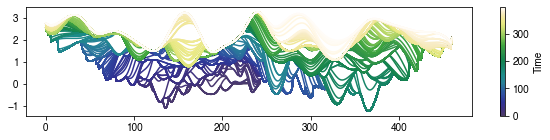

In [49]:
plt.figure(figsize = (10,2))
for i in range (0, end_t):
    plt.plot(xy_topo[i], color = cpick.to_rgba(i))
plt.colorbar(cpick,label="Time")
print(f'Last timestep is {end_t}')

In [50]:
st_time = int(input('Enter start model timestep for video: '))
en_time = int(input('Enter end model timestep for video: '))

barleft = int(input('Enter left limit of plot here: '))
barright = int(input('Enter right limit of plot here: '))
buffer = 50 #some extra buffer space to account for widening during the run
rblim = data[:, 3, :].min()+barleft-(buffer/2)
lblim = rblim+(barright-barleft+(buffer/2))

barnm = input('Enter name of bar here: ')

Enter start model timestep for video: 200
Enter end model timestep for video: 350
Enter left limit of plot here: 100
Enter right limit of plot here: 200
Enter name of bar here: tranis


MovieWriter imagemagick unavailable; using Pillow instead.


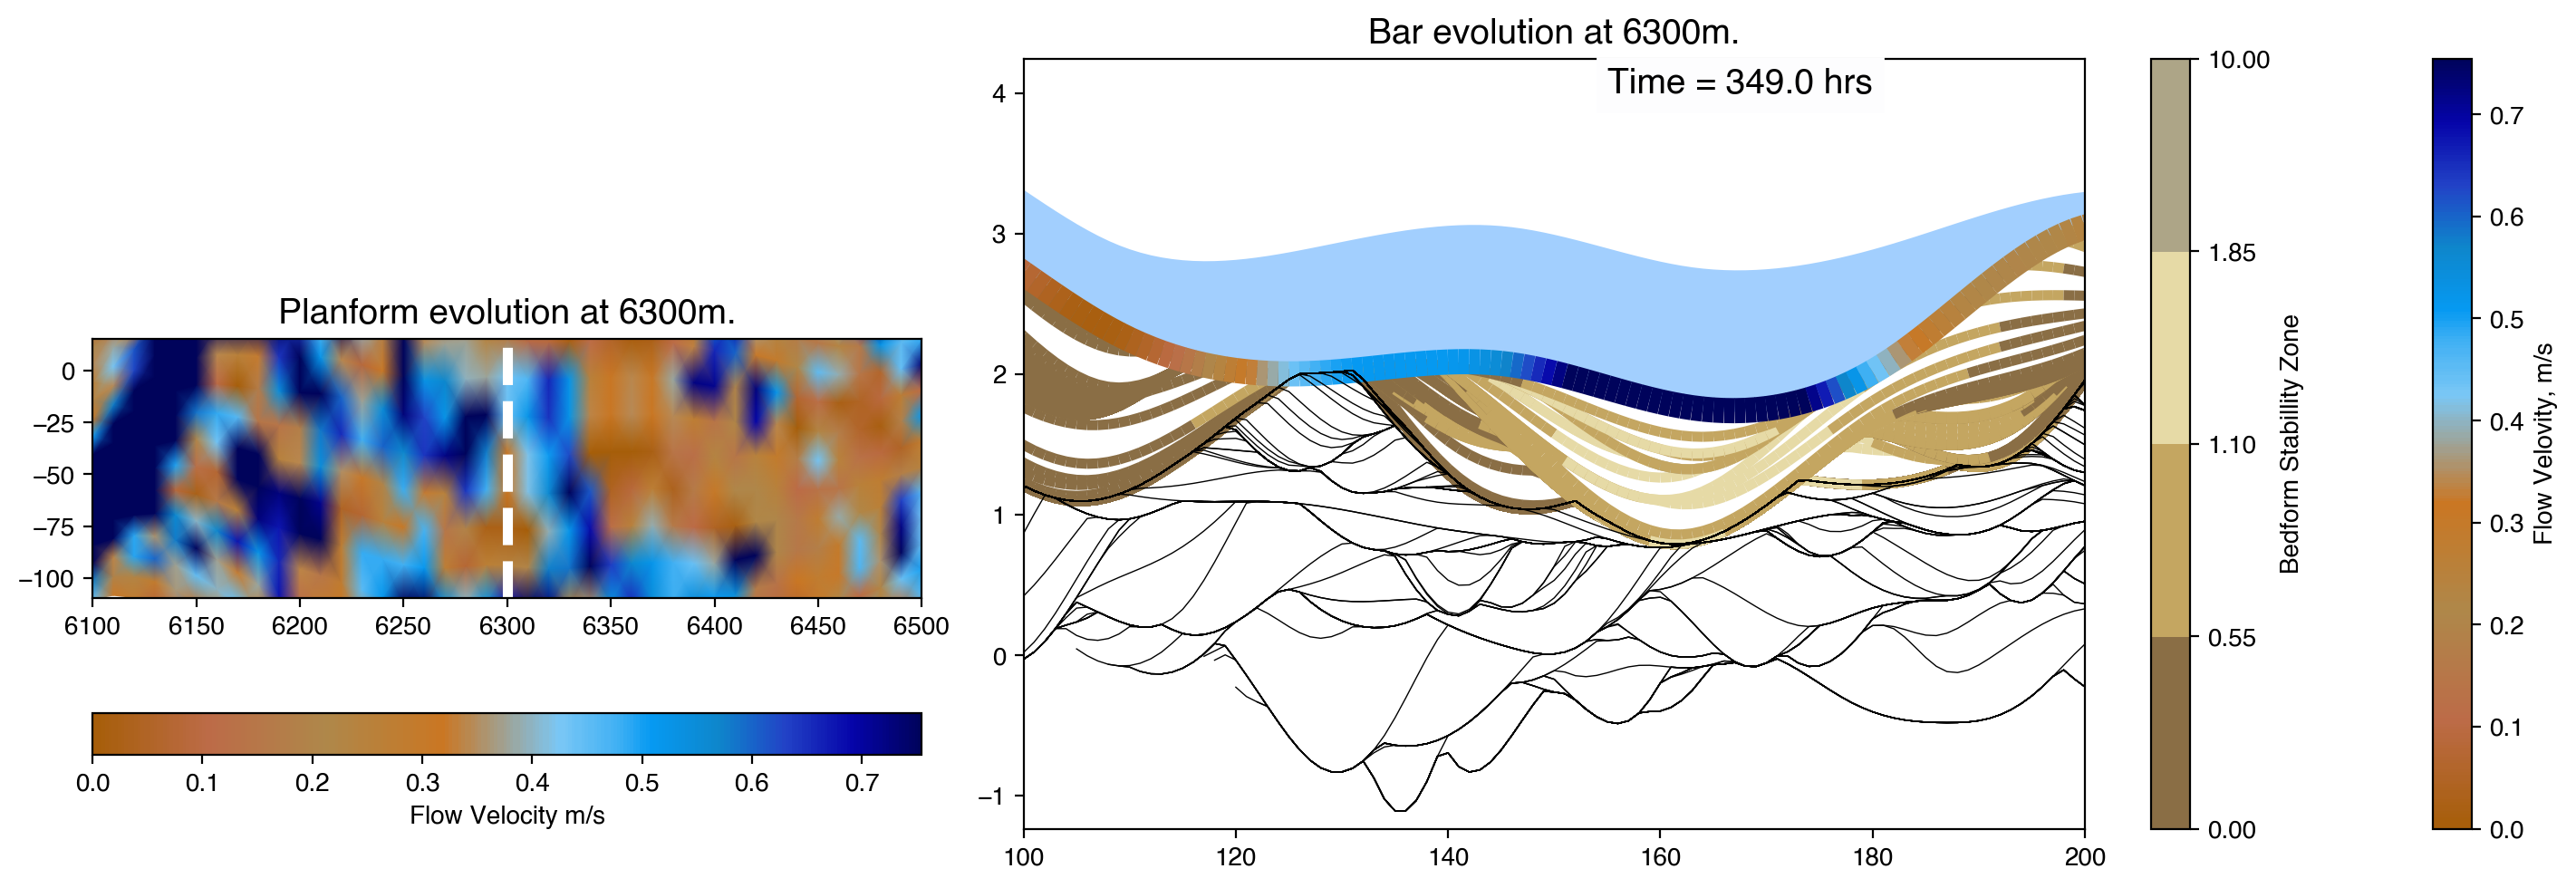

In [51]:
strat_4plot = copy.deepcopy(strat)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5), gridspec_kw={'width_ratios': [1, 2]}, tight_layout =True, dpi = 200)

ax2.set_xlim(barleft, barright)
ax2.set_ylim(np.nanmin(strat), np.nanmax(strat))

ax1.set_ylim(rblim, lblim)
#set up for topo plot
xdomain = np.reshape(datamaster[:, 2, -1], (gridy, gridx))
ydomain = np.reshape(datamaster[ :, 3, -1] , (gridy, gridx))
elev = np.reshape(datamaster[:, char, st_time-1], (gridy, gridx))

camera = Camera(fig)
ax1.set_aspect('equal')
for time in range (0, en_time):

    for space in range (0, strat_4plot.shape[1]):
        preexisting_strata = strat_4plot[:time, :] #this is our search array, where we will erode
        
        willerode = np.where(preexisting_strata[:, space] > strat_4plot[time, space])
        
        strat_4plot[willerode, space] = strat_4plot[time, space]
            
    #for t in range (0, time):
    #    ax2.plot(xy_topo[t], color = cpick.to_rgba(t), lw = 1)
    
    ##velint = flowvel[time]
    #for t in range(0, st_time):
    #    plt.plot(strat_4plot[t], color = 'k', lw = 0.5)
    
    for pret in range (st_time, time):
        
        # Plot TIME
        #ax2.plot(strat_4plot[pret], color = cpick.to_rgba(pret), lw = 3)
   
        # Plot FACIES
        elevint = strat_4plot[pret]
        pointsint = np.array([posnew, elevint]).T.reshape(-1, 1, 2)
        segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)
        velint = flowvel[pret]
        velofacies = LineCollection(segmentsint, cmap = cmap_velfac, norm = norm_velfac)
        velofacies.set_array(velint)
        velofacies.set_linewidth(4)
        velofacies_line = ax2.add_collection(velofacies)
        #pt = pret #variable to store last value of pret
    
    #fill = ax2.fill_between(posnew, strat_4plot[time-1], strat_4plot[time], color=cpick.to_rgba(time), alpha = 1)
    
    #while time < en_time:
    ax2.fill_between(posnew, trueflow[time, :]+strat[time, :], strat[time, :], 
                     where=trueflow[time, :]+strat[time, :] > strat[time, :], color = '#a2cffe')
    
    #ax2.set_facecolor('xkcd:grey')

    elevint = strat_4plot[time]
    pointsint = np.array([posnew, elevint]).T.reshape(-1, 1, 2)
    segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)
    velint = flowvel[time]   
    velogradint = plt.Normalize(np.nanmin(velint), np.nanmax(velint)) ##gradient plot for flow velocity
    vel_mix = LineCollection(segmentsint, cmap=get_continuous_cmap(test), norm=cropnorm)
    vel_mix.set_array(velint)
    vel_mix.set_linewidth(10)
    vel_mix_line = ax2.add_collection(vel_mix)

    xdomain = np.reshape(datamaster[:, 2, time], (gridy, gridx))
    ydomain = np.reshape(datamaster[ :, 3, time] , (gridy, gridx))
    elev = np.reshape(datamaster[:, char, time], (gridy, gridx))
    
    ax1.axvline(xsloc, c='w', ls='--', lw = 4)
    crp = ax1.pcolormesh(xdomain, ydomain, elev, cmap = get_continuous_cmap(test), norm = cropnorm, shading = 'gouraud')
    #ax1.pcolormesh(xdomain, ydomain, elev,cmap = get_continuous_cmap(centrelines), norm = cropnorm, shading = 'gouraud', alpha = 1)
    ax1.set_xlim(bhead*cellL, btail*cellL)
    wtf = time*interval_to_plot
    ax2.text(barright-45, np.nanmax(strat)-0.25, f'Time = {wtf} hrs', fontsize = 14, color = 'k', backgroundcolor = 'xkcd:pale grey', weight = 500)
    #ax1.set_title(f'Planform evolution at {iloc*cellL}m. Time = {wtf} hours', fontsize = 14)
    camera.snap()

#     cb.remove()
#     cbv.remove()
#     cbt.remove()
    #ax.clear()
    #ax3.clear()
cb = fig.colorbar(crp, label = 'Flow Velocity m/s', ax=ax1, orientation = 'horizontal')
cbv = fig.colorbar(vel_mix_line, label = 'Flow Velovity, m/s', ax=ax2)
cbt = fig.colorbar(velofacies_line, label="Bedform Stabillity Zone", ax=ax2)
ax2.set_title(f'Bar evolution at {iloc*cellL}m.', fontsize = 14)
ax1.set_title(f'Planform evolution at {iloc*cellL}m.', fontsize = 14)

animation = camera.animate()  
animation.save(f'{savefilesto}gifs/{modelrun}-{barnm}tst.gif', writer = 'imagemagick')

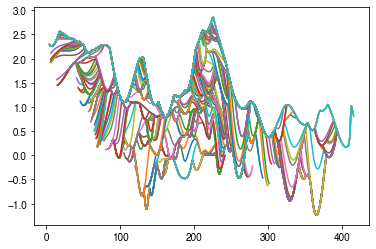

In [52]:
## Plot local slope for section



## Heat Maps

In [444]:
## create difference matrix
#SICslice = np.delete(xy_topo, 0, axis = 0) 
#TOPOslice = np.delete(strat, -1, axis = 0) 
#difference = SICslice-TOPOslice #differencing method rather than searching +ve diff = erosion, -ve =depo hia_range = np.percentile(difference, 1)
difference = thickness
diff_fraction = difference/(difference.max())
#print(difference.shape)
diff_llim= difference.min()
diff_ulim = difference.max()

vel_llim = flowvel.min()
vel_ulim = flowvel.max()

vels_frac = flowvel/vel_ulim

In [445]:
class MidpointNormalize(mcol.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        mcol.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [446]:
#normalise = plt.Normalize(-1, 2)
midnorm = MidpointNormalize(vmin=diff_llim, vcenter=0, vmax=diff_ulim)
midnorm11 = MidpointNormalize(vmin=-1, vcenter=0, vmax=1)
toponorm = MidpointNormalize(vmin=np.nanmin(xy_topo), vcenter=0, vmax=np.nanmax(xy_topo))
normalise = plt.Normalize(0, 1)
#midnorm = MidpointNormalize(vmin=-1, vcenter=0, vmax=2)

-0.9828297368842962 1.0


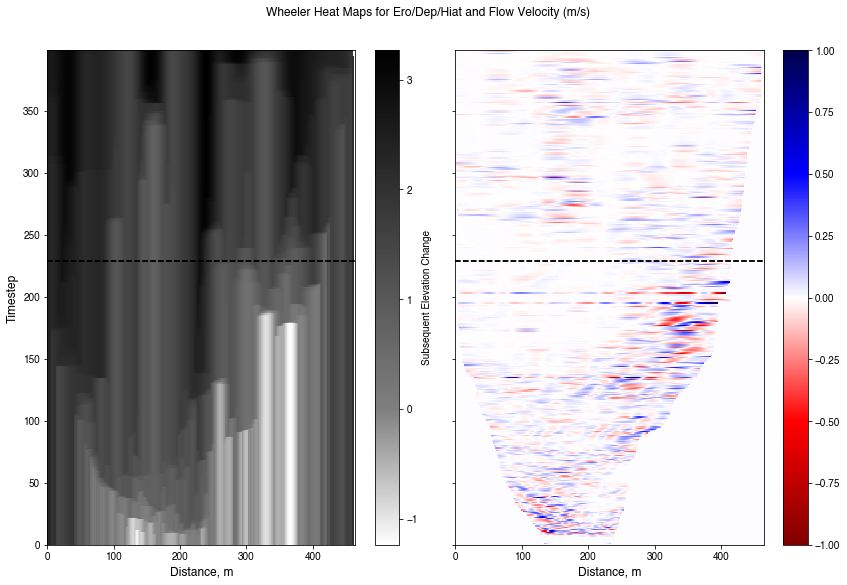

In [447]:
fig, ax = plt.subplots(1,2, figsize = (12, 8), tight_layout = True, sharex = True, sharey = True)


absol = ax[0].pcolormesh(xy_topo, cmap = 'binary', norm = toponorm, shading = 'flat', snap = True)
frac = ax[1].pcolormesh(diff_fraction, cmap = 'seismic_r', norm = midnorm11, shading = 'flat', snap = True)

#absolv = ax[1,0].pcolormesh(velocub, cmap = 'YlGnBu', norm = velogradint, shading = 'flat', snap = True)
#fracv = ax[1,1].pcolormesh(vels_frac, cmap = 'YlGnBu', norm = normalise, shading = 'flat', snap = True)

#fig.colorbar()
ttl = fig.suptitle('Wheeler Heat Maps for Ero/Dep/Hiat and Flow Velocity (m/s)')
ttl.set_position([0.5, 1.01])
#fig.tight_layout()
#fig.subplots_adjust(top=10)

fig.colorbar(absol, ax = ax[0], label = 'Subsequent Elevation Change')
fig.colorbar(frac, ax = ax[1])
#fig.colorbar(absolv, ax = ax[1,0], label = "Flow Velocity, m/s")
#fig.colorbar(fracv, ax = ax[1,1])

ax[0].axhline(fldstart, c='k', ls = '--')
ax[0].axhline(fldstart+fldlength/interval_to_plot, c='k', ls = '--')

ax[1].axhline(fldstart, c='k', ls = '--')
ax[1].axhline(fldstart+fldlength/interval_to_plot, c='k', ls = '--')

ax[0].set_ylabel('Timestep', fontsize = 12)
ax[0].set_xlabel('Distance, m', fontsize = 12)
ax[1].set_xlabel('Distance, m', fontsize = 12)
print(diff_fraction.min(), diff_fraction.max())
#plt.savefig(savefilesto+'ero_dep_wheeler/'+modelrun+'.png', dpi = 100)

Find the left and right edges of depositional packages, append depositional matrix to get co-ordintes of rectangles for wheeler diagram.

In order for the logic statement to work to find the polygons, I created a border of nans around all ofthe arrays 

In [448]:
nan_border = np.empty([end_t, 1])
nan_border.shape
nan_border[:] = np.nan
#topointerp_nb = np.concatenate((nan_border, strat, nan_border), axis = 1) #nb = nan border
stratinterpcub_nb = np.concatenate((nan_border, xy_topo, nan_border), axis = 1)
erosurf_nb = np.concatenate((nan_border, erosurf, nan_border), axis = 1)
deposurf_nb = np.concatenate((nan_border, deposurf, nan_border), axis = 1)

hiatalsurf_nb = np.concatenate((nan_border, hiatalsurf, nan_border), axis = 1)
erohiatalsurf_nb = np.concatenate((nan_border, erohiatalsurf, nan_border), axis = 1)
posnew = np.arange(0, xy_topo.shape[1], dtype = float)
posnew_nb = np.insert(posnew, [0], [np.nan])
posnew_nb = np.insert(posnew_nb, -1, np.nan)

In [449]:
#was trying tosee if you can plot the topo at the same time of the erosion surffaces only, but the that ends up plotting all the topo
time_erohiat = np.empty_like(ages_ero) #will store only the ages of the erosional and hiatal surfaces
time_erohiat[:] = np.nan

EHindex = np.where(stratcondition != 0) #find and remove locations of deposition

time_erohiat[EHindex] = ages_ero[EHindex] #add ages to locations of erosion and hiatuses only

boundary_time_notnan = time_erohiat[~np.isnan(time_erohiat)]

boundary_time = np.unique(boundary_time_notnan)

print(boundary_time.shape)
boundary_time = np.sort(boundary_time)

#for time in boundary_time:
#    plt.plot(posnew, stratinterpcub[int(time)])

(399,)


In [450]:
depcontrol = deposurf_nb.copy()
depcontrol[~np.isnan(depcontrol)] = 1
erocontrol = erosurf_nb.copy()
erocontrol[~np.isnan(erocontrol)] = 1
#erocontrol[~np.isnan()]

## Wheeler Diagram

In [451]:
#print(len(posnew_nb))
l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
l_index = np.empty([1,]) #index value of left edge
r_edges = np.empty([1,]) #right edge of the wheeler fill
r_index = np.empty([1,]) #index value of right edge
dep_age = np.empty([1,]) #age of each deposit for the wheeler diagram
for i in range (0,end_t):
    #if ~np.isnan(deposurf[i, 0]):
    #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

    for xpos in range (0, len(posnew_nb)-1):
        l_edge = np.all((np.isnan(deposurf_nb[i, xpos]) and ~np.isnan(deposurf_nb[i, xpos+1])))
        r_edge = np.all((~np.isnan(deposurf_nb[i, xpos]) and np.isnan(deposurf_nb[i, xpos+1])))
        
        if l_edge == True:
            l_edges = np.append(l_edges, [posnew_nb[xpos+1]], axis = 0)
            l_index = np.append(l_index, [xpos+1], axis = 0)
            #print(posnew_nb[xpos+1], 'potato')
        if r_edge == True:
            #print(xpos, 'tomato')
            r_edges = np.append(r_edges, [posnew_nb[xpos-1]], axis = 0)
            r_index = np.append(r_index, [xpos+1], axis = 0)
            dep_age = np.append(dep_age, [i], axis = 0)
        
#print('L', l_edges)
#print('R',r_edges)
#print(dep_age)

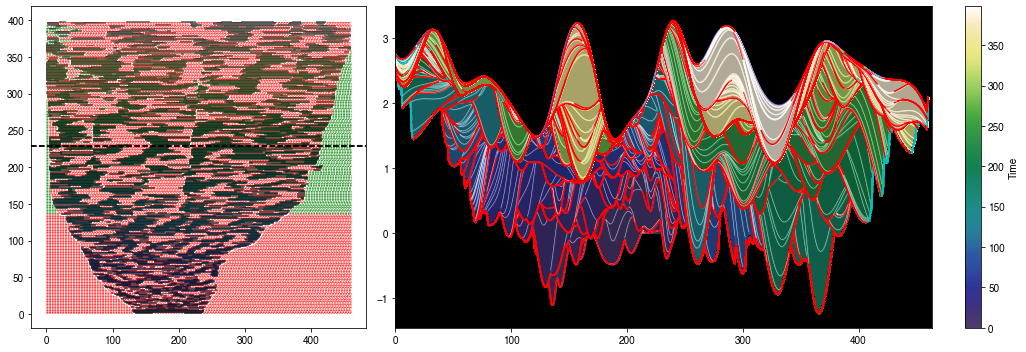

In [452]:
##Now we concatenate the L and R and age arrays to form a database to plot the rectangles
l_edges = np.reshape(l_edges, [len(l_edges), 1])
r_edges = np.reshape(r_edges, [len(r_edges), 1])
dep_age = np.reshape(dep_age, [len(dep_age), 1])

rectangles = np.empty([len(l_edges), 5])
rectangles[:, 0] = dep_age[:, 0]
rectangles[:, 1] = l_edges[:, 0]
rectangles[:, 2] = r_edges[:, 0]
rectangles[:, 3] = rectangles[:, 2]-rectangles[:, 1]
rectangles[:, 4] = 1
#print(rectangles)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5), gridspec_kw={'width_ratios': [1, 2]}, tight_layout =True)
for i in range (1, len(rectangles)):
    #rect = plt.Rectangle((rectangles[i,1], rectangles[i,0]), rectangles[i,3], rectangles[i,4], color=cpick.to_rgba(rectangles[i, 0]), ec = 'k', linewidth = 0.5)
    ax1.add_patch(plt.Rectangle((rectangles[i,1], rectangles[i,0]), rectangles[i,3], rectangles[i,4], color=cpick.to_rgba(rectangles[i, 0]), ec = 'k', linewidth = 0.5))
    
for i in range(0, end_t):
    ax1.plot(posnew_nb, i*erocontrol[i, :], 'r--', linewidth = 0.5)
    ax1.plot(posnew, i*(hiatalsurf[i, :]/hiatalsurf[i, :]), 'g--', linewidth = 0.5)
    #ax1.plot(posnew_nb, i*depcontrol[i, :], 'b.', linewidth = 0.5)

for i in range (0, end_t-1):
    ax2.fill_between(posnew, xy_topo[i+1], xy_topo[i], color=cpick.to_rgba(i), alpha = .7)
    #polys = PolyCollection.get_clip_path(self)

#Plot topo in black to find main surfaces    
for i in range (0, end_t):
    #ax1.plot(posnew, stratinterpcub[i], 'k', lw = '1', alpha = 0.1)
    ax2.plot(posnew, erosurf[i], 'r', lw='1.5', alpha = 1)
    ax2.plot(posnew, hiatalsurf[i], 'c', lw='1.5', alpha = 1)
    ax2.plot(posnew, deposurf[i], 'w', lw='0.5', alpha = 0.7)

    
ax1.axhline(fldstart, c='k', ls = '--')
ax1.axhline(fldstart+fldlength/interval_to_plot, c='k', ls = '--')

ax2.plot(posnew, erosurf[end_t-1], 'r', lw='1.5', alpha = 1)
ax2.plot(posnew, deposurf[end_t-1], 'b', lw='0.5', alpha = 0.7)
ax2.plot(posnew, hiatalsurf[end_t-1], 'y', lw='1.5', alpha = 1)
ax2.set_facecolor('k')
plt.xlim(0, posnew.max())
#plt.ylim(0, num_timesteps)
fig.colorbar(cpick,label="Time", ax=ax2)
plt.savefig(savefilesto+'wheeler/'+modelrun+'.png', dpi = 100)

In [363]:
SIC_startcrop = copy.deepcopy(xy_topo)
SIC_startcrop = np.concatenate((nan_border, SIC_startcrop, nan_border), axis = 1)

SIC_startcrop = np.delete(SIC_startcrop, 0, axis = 0)
SIC_startcrop.shape

SIC_endcrop = copy.deepcopy(xy_topo)
SIC_endcrop = np.concatenate((nan_border, SIC_endcrop, nan_border), axis = 1)

SIC_endcrop = np.delete(SIC_endcrop, -1, axis=0)
SIC_endcrop.shape

delta = SIC_startcrop-SIC_endcrop

delta[np.where(delta[:]==0)] = np.nan


## Create the left and right vertices of each polygon

In [364]:

#print(len(posnew_nb))
#l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
l_idx = np.empty([1,]) #index value of left edge
#r_edges = np.empty([1,]) #right edge of the wheeler fill
r_idx = np.empty([1,]) #index value of right edge
surf_age = np.empty([1,]) #age of each deposit for the wheeler diagram
for i in range (0, len(delta)):
    #if ~np.isnan(deposurf[i, 0]):
    #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

    for xpos in range (0, len(posnew_nb)-1):
        l_edge = np.all((np.isnan(delta[i, xpos]) and ~np.isnan(delta[i, xpos+1])))
        r_edge = np.all((~np.isnan(delta[i, xpos]) and np.isnan(delta[i, xpos+1])))
        #print(xpos, 'L', l_edge)
        #print(xpos, 'R', r_edge)
        if l_edge == True:
            #l_edges = np.append(l_edges, [posnew_nb[xpos+1]], axis = 0)
            l_idx = np.append(l_idx, [xpos], axis = 0)
            #print(posnew_nb[xpos+1], 'potato')
            surf_age = np.append(surf_age, [i], axis = 0)
        if r_edge == True:
            #print(xpos, 'tomato')
            #r_edges = np.append(r_edges, [posnew_nb[xpos-1]], axis = 0)
            r_idx = np.append(r_idx, [xpos], axis = 0)
            
#surf_age = np.append(surf_age, [i+1], axis = 0)
#print('L', l_edges)
#print('R',r_edges)
#print(dep_age)

Store all those vertices in an array that houses the time of each polygon and the left and right edges of the poly

In [365]:
l_idx = np.reshape(l_idx, [len(l_idx), 1])
#l_index = np.delete(l_index, 1)

l_idx = l_idx.astype(int)
r_idx = np.reshape(r_idx, [len(r_idx), 1])
#r_index = np.delete(r_index, 1)
r_idx = r_idx.astype(int)

#print(l_idx[:, 0], r_idx[:, 0])
surf_age = np.reshape(surf_age, [len(surf_age), 1])

print(l_idx.shape, r_idx.shape, surf_age.shape)

vertices_b = surf_age
vertices_b = np.append(vertices_b, l_idx, axis = 1)
vertices_b = np.append(vertices_b, r_idx, axis = 1)

#print(vertices)#, vertices.shape)


cent_array = np.empty([len(vertices_b), 8])
cent_array[:] = np.nan

(733, 1) (733, 1) (733, 1)


In [366]:
## Plot the filled stratigraphy, create a polygon for each, find the centroid, store the centroid and its age
testfig, ax1 = plt.subplots(1, 1, tight_layout=True, squeeze=True, figsize = (10,6))
poly_data = {}
for i in range (1, len(vertices_b)):
    time = int(vertices_b[i, 0])
    left = int(vertices_b[i, 1])
    right = int(vertices_b[i, 2])

    poly = ax1.fill_between(posnew[left:right], xy_topo[time, left:right], xy_topo[time+1, left:right], color=cpick.to_rgba(i))
    pverts = poly.get_paths()[0].vertices
    
    polygon = Polygon(pverts) #create a shapely polygon
    #print(polygon)
    poly_data[i] = polygon
    area = polygon.area
    bounds = polygon.bounds
    #print(type(bounds[0]))
    cent_array[i, 4] = bounds[0]
    cent_array[i, 5] = bounds[1]
    cent_array[i, 6] = bounds[2]
    cent_array[i, 7] = bounds[3]
    cent_array[i, 3] = area
    ctroid = polygon.centroid
    cent_array[i, 0] = time
    cent_array[i, 1] = ctroid.x
    cent_array[i, 2] = ctroid.y

    
    #ax1.plot(cent_array[i, 1], cent_array[i, 2], 'k*')
#ax1.set_facecolor('xkcd:midnight blue')
    

ax1.set_xlim(posnew.min(), posnew.max())
#ax1.set_ylim(xy_topo.min(), xy_topo.max())
#print('12', poly_data[12])
plt.close(testfig)
#for i in range (0, num_timesteps-1):
#   plt.plot(posnew, stratinterpcub[i, :], 'k')


## Coring the stratigraphy

In [367]:
coresthick = {} #dictionary to hold set thickness
coresbounds = {} #dictionary to hold bound surfaces
num_sets = np.empty([len(posnew), 2])
num_sets[:, 0] = posnew
threshold = 0.1
for i in range(0, len(posnew)):
    keystr = 'x'+str(i)
    
    elevatcore = np.delete(erohiatalsurf[:, i], np.where(np.isnan(erohiatalsurf[:, i])))
    bounds = np.unique(elevatcore)
    #print(i, bounds)
    
    coresbounds[keystr] = bounds #finds the bounding elevations of sets
    
    diffs = np.empty([0])
    
    for j, k in zip(bounds[:-1], bounds[1:]):
        #print(i, j, k)
        diff = k-j #more positive -- less positive = positive
        #print(diff)
        if diff > threshold:
            diffs = np.append(diffs, diff)


    coresthick[keystr] = diffs
    num_sets[i, 1] = len(diffs)
    
    #print(cores[keystr+'_thick'])
#print(cores)


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Stratigraphy at 300. Ero = red, Hiatal = green')

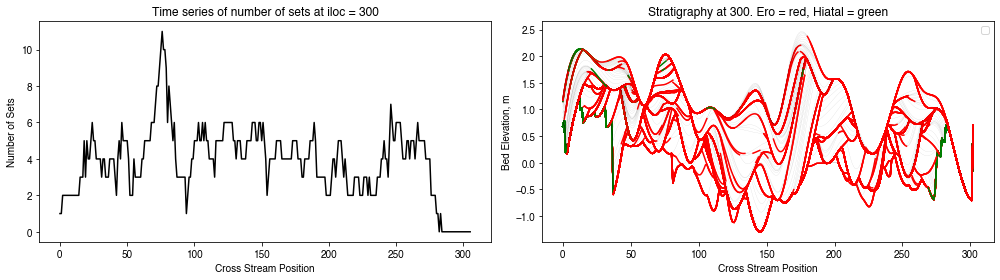

In [368]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4), tight_layout=True)
ax[0].plot(num_sets[:, 0], num_sets[:, 1], 'k')
for i in range (0, end_t):
    ax[1].plot(posnew, xy_topo[i], 'k', lw = 0.1, alpha = 0.4)
    ax[1].plot(posnew, erosurf[i], 'r', lw = 1.5)
    ax[1].plot(posnew, hiatalsurf[i], 'g', lw = 1.5)
ax[1].set_ylabel('Bed Elevation, m')
ax[0].set_ylabel('Number of Sets')
ax[1].set_xlabel("Cross Stream Position")
ax[0].set_xlabel("Cross Stream Position")
ax[1].legend()

ax[0].set_title('Time series of number of sets at iloc = '+str(iloc))
ax[1].set_title('Stratigraphy at '+str(iloc)+'. Ero = red, Hiatal = green')

/Applications/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, '300')

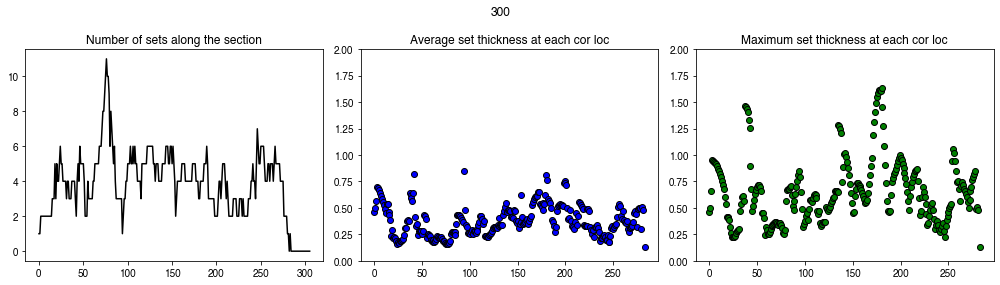

In [369]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4), tight_layout = True)
ax[0].plot(num_sets[:, 0], num_sets[:, 1], 'k')
ax[0].set_title('Number of sets along the section')

for loc, core in zip(posnew, coresthick):
    avg = np.average(coresthick[core])
    #print(coresthick[core], avg)
    if len(coresthick[core]) >0:
        ax[1].plot(loc, np.average(coresthick[core]), 'o', markerfacecolor = 'b', markeredgecolor = 'k')
        ax[2].plot(loc, coresthick[core].max(), 'o', markerfacecolor = 'g', markeredgecolor = 'k')
        
ax[2].set_ylim(0, 2)
ax[1].set_ylim(0, 2)

ax[2].set_title('Maximum set thickness at each cor loc')
ax[1].set_title('Average set thickness at each cor loc')

fig.suptitle(str(iloc))

#plt.savefig(savefilesto+'/corestats/'+modelrun+'.png', dpi = 100)

Centroids are being plotted in very tiny polygons so this is a bit of code to delete the centroids of the polygons with the 10th percentile smallest area


In [370]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
#too_small_area = (cent_array[np.where(abs(cent_array[:, 3])<0.000001)])
#print(cent_array[:, 3])
ax1.hist(cent_array[:, 3])
ptile10 = np.nanpercentile(cent_array[:, 3], 10)

print(ptile10)
ax1.axvline(ptile10, c = 'r')

cent_wnan = copy.deepcopy(cent_array)
deletewhere = np.where(cent_array[:, 3] < ptile10)
cent_wnan[deletewhere] = np.nan

cent_nonan = cent_wnan[~np.isnan(cent_wnan).any(axis = 1)] #delete all rows in cent_wnan matrix with nan values

ax2.hist(cent_nonan[:, 0])
ax1.set_title('Distribution of polygon areas woth 10thp', fontsize = 12)
ax2.set_title('distribution of ages of polys with area > 10thp', fontsize = 12)
textstr1 = str(len(cent_array))
textstr2 = len(cent_nonan)
ax1.set_xlabel('polygon area')
ax2.set_xlabel('deposit age (10s of min)')
ax1.text(2, 200, 'n='+str(len(cent_array)))
ax2.text(25, 40, 'n='+str(len(cent_nonan)))
plt.close(fig)

0.003852770431089971


In [371]:
fig, ax = plt.subplots(1, tight_layout = True, figsize = (15, 5), dpi = 200)
for i in range (0, end_t-1):
    #ax.plot(posnew, stratinterpcub[i], cpick.to_rgba(i), lw = 0.5, alpha = 0.4)
    ax.fill_between(posnew, xy_topo[i+1], xy_topo[i], color=cpick.to_rgba(i), alpha= 0.5, linewidth = 0.0)
    #ax.plot(posnew, erohiatalsurf[i], 'r', lw = 1, alpha = 0.5)

    #ax.plot(cent_array[i, 1], cent_array[i, 2], marker = '*', markerfacecolor = 'k', markeredgecolor = 'k', mew = .5,   ms = 4, alpha = 1)
for i in range (0, end_t):#,5):
    #ax.plot(posnew, stratinterpcub[i], color = 'xkcd:midnight blue',  ls = '--', lw = .8, alpha = .3)
    #ax.plot(cent_wnan[i, 1], cent_array[i, 2], marker = '.', markerfacecolor = cpick.to_rgba(cent_array[i, 0]), markeredgecolor = 'k', mew = .1,   ms = 5, alpha = 1)
    ax.plot(posnew, erohiatalsurf[i], 'k', lw = 1, alpha = .2)
for i in range (1, len(vertices_b)):
    ax.plot(cent_wnan[i, 1], cent_wnan[i, 2], marker = 'o', markerfacecolor = 'k', markeredgecolor = 'k', mew = .5,   ms = 5, alpha = 1)
for i in range (1, len(cent_nonan)):
    ax.plot(cent_nonan[i, 1], cent_nonan[i, 2], marker = 'o', color = cpick.to_rgba(cent_nonan[i, 0]), markeredgecolor = 'k', mew = .5,   ms = 5, alpha = 1)
print(erohiatalsurf.shape)
print(posnew.shape)
ax.set_facecolor('xkcd:grey')
fig.colorbar(cpick,label="Time, min", ax=ax)
#ax.set_xlim((200, 300))
ax.set_xlim(posnew.min(), posnew.max())
#ax.set_ylim(xy_topo.min(), xy_topo.max())

ax.set_xlabel('Cross Stream Distance, m')
ax.set_ylabel('Bed Elevation, m')
#cpick.to_rgba(cent_wnan[i, 0]), marker color by time
#ax.set_ylim(stratinterpcub.min(), stratinterpcub.max())
plt.title(f'Stratigraphy at {iloc*10} km')
#plt.savefig(savefilesto+'herofig/'+modelrun+'.png', dpi = 100)

(399, 306)
(306,)


Text(0.5, 1.0, 'Stratigraphy at 3000 km')

Error in callback <function flush_figures at 0x7f8f132570d0> (for post_execute):


KeyboardInterrupt: 

age, cent x (1), cent y (2), cent area (3), pol minx (4), pol miny (5), pol maxx (6), pol maxy (7), pol width (8), pol heigt (9), distance (10), reltime (11), delx (12), dely (13)

In [372]:
print(cent_nonan[:5, 4])
print(cent_nonan[:5, 6])
poly_widths = cent_nonan[:, 6]-cent_nonan[:, 4]
poly_widths = np.reshape(poly_widths, [len(poly_widths), 1])

poly_heights = cent_nonan[:, 7]-cent_nonan[:, 5]
poly_heights = np.reshape(poly_heights, [len(poly_heights), 1])
#print(poly_widths.shape)

cent_nonan = np.concatenate((cent_nonan, poly_widths, poly_heights), axis = 1)

[197. 197. 187. 197. 180.]
[202. 202. 193. 202. 192.]


In [373]:
range_x = position.max()-position.min()
range_y = np.nanmax(xy_topo)-np.nanmin(xy_topo)
print(range_x, range_y)

305.0 3.759041452262407


In [374]:
dists = np.zeros([len(cent_nonan[:, 3]), 1])
reltime = np.zeros([len(cent_nonan[:, 3]), 1]) #will store the elapsed time between two consecutive centroids
delx = np.zeros([len(cent_nonan[:, 3]), 1])
dely = np.zeros([len(cent_nonan[:, 3]), 1])

for i in range (0, len(cent_nonan)-1):
    dists[i, 0] = ((cent_nonan[i+1, 1]-cent_nonan[i, 1])**2+(cent_nonan[i+1, 2]-cent_nonan[i, 2])**2)**0.5
    reltime[i,0] = cent_nonan[i+1, 0]-cent_nonan[i, 0]
    delx[i, 0] = abs(cent_nonan[i+1, 1]-cent_nonan[i, 1])/range_x
    dely[i, 0] = abs(cent_nonan[i+1, 2]-cent_nonan[i, 2])/range_y
cent_nonan = np.concatenate((cent_nonan, dists, reltime, delx, dely), axis = 1)
print(cent_nonan.shape)

(658, 14)


In [375]:
delx = np.delete(delx, -1, axis=0)
dely = np.delete(dely, -1, axis=0)

## SAVE CENTROIDS

In [376]:
#np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/centroids/{arrayfolder}/c{iloc}', cent_nonan)

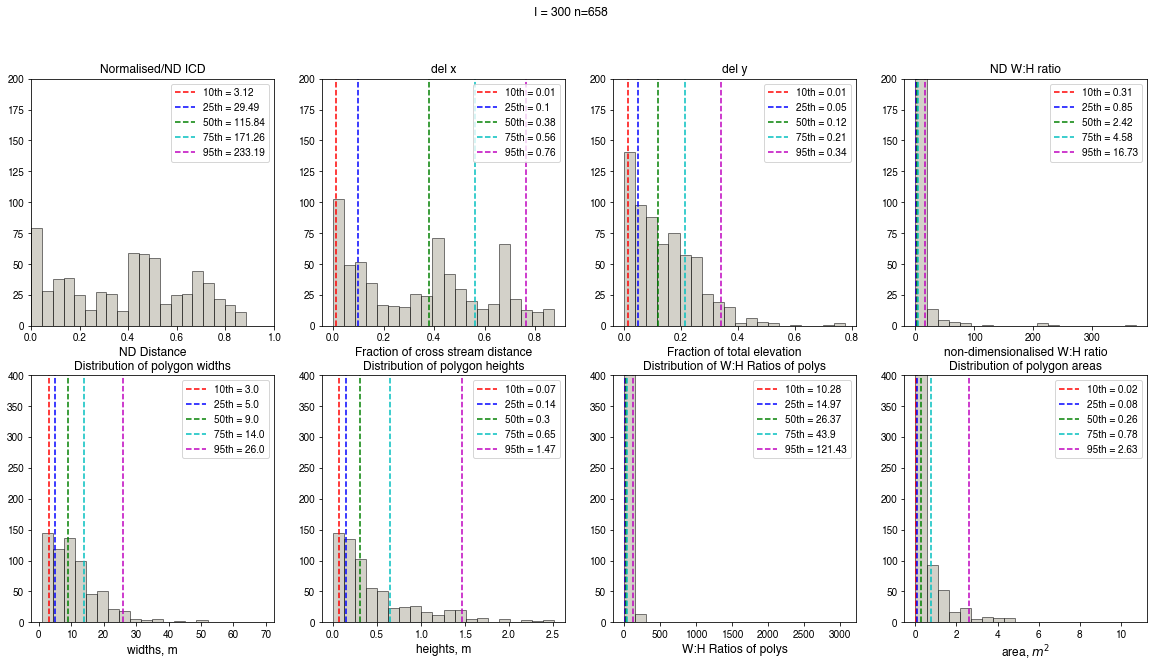

In [377]:
nbins = 1+3.122*math.log(len(cent_nonan), 10)
nbins = roundup(nbins, 10)

fig, ax = plt.subplots(2,4, figsize = (20,10))

## del ICD
deldist = (delx**2+dely**2)**0.5
ax[0,0].hist(deldist, **kwargs)
ax[0,0].set_title('Normalised/ND ICD', fontsize = 12)
ax[0,0].set_xlabel('ND Distance',  fontsize = 12)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlim(0, 1)
## del x
ax[0,1].hist(cent_nonan[:, 12], **kwargs)
ax[0,1].set_title('del x',  fontsize = 12)
ax[0,1].set_xlabel('Fraction of cross stream distance',  fontsize = 12)
ax[0,1].set_ylim(0, 200)
## del y
ax[0,2].hist(cent_nonan[:, 13],  **kwargs)
ax[0,2].set_title('del y',  fontsize = 12)
ax[0,2].set_xlabel('Fraction of total elevation',  fontsize = 12)
ax[0,2].set_ylim(0, 200)
## distance in terms of del x and del y
#
delxdely = delx/dely
ax[0, 3].hist(delxdely,  **kwargs)
ax[0, 3].set_title('ND W:H ratio',  fontsize = 12)
ax[0, 3].set_xlabel('non-dimensionalised W:H ratio',  fontsize = 12)
ax[0, 3].set_ylim(0, 200)
## polygon widths
ax[1,0].hist(cent_nonan[:, 8],  **kwargs)
ax[1,0].set_title('Distribution of polygon widths', fontsize = 12)
ax[1,0].set_xlabel('widths, m',  fontsize = 12)
ax[1,0].set_ylim(0, 400)
#polygon heights
ax[1,1].hist(cent_nonan[:, 9], **kwargs)
ax[1,1].set_title('Distribution of polygon heights', fontsize = 12)
ax[1,1].set_xlabel('heights, m',  fontsize = 12)
ax[1,1].set_ylim(0, 400)
#polygon w:H ratio
ax[1,2].hist(cent_nonan[:, 8]/cent_nonan[:, 9], **kwargs)
ax[1,2].set_title('Distribution of W:H Ratios of polys', fontsize = 12)
ax[1,2].set_xlabel('W:H Ratios of polys',  fontsize = 12)
ax[1, 2].set_ylim(0, 400)
## polygon areas
ax[1, 3].hist(cent_nonan[:, 3], **kwargs)
ax[1, 3].set_title('Distribution of polygon areas',  fontsize = 12)
ax[1, 3].set_xlabel('area, $m^2$',  fontsize = 12)
ax[1, 3].set_ylim(0, 400)

ptiles = np.array([10, 25, 50, 75, 95])
ptile_store = np.empty([8, len(ptiles)])

indexlist = [cent_nonan[:, 10], cent_nonan[:, 12], cent_nonan[:, 13], delxdely, cent_nonan[:, 8], cent_nonan[:, 9], cent_nonan[:, 8]/cent_nonan[:, 9],cent_nonan[:, 3]]
colours = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
ax = ax.ravel()

for i in range(0, len(ax)):

    ptile_store[i, :] = np.percentile(indexlist[i], ptiles)
    for j in range (0, len(ptiles)):
        ax[i].axvline(ptile_store[i, j], c = colours[j], ls = '--', label = str(ptiles[j])+'th = '+ str(round(ptile_store[i, j], 2))) 
        #ax[i].axvline(ptile_store[i, j], c = 'b', ls = '--', label = '25th = '+ str(round(icd_ptiles[1])))
        #ax[i].axvline(ptile_store[i, j], c = 'g', ls = '--', label = '50th = '+ str(round(icd_ptiles[2])))
    ax[i].legend()
#icd_ptiles = np.percentile(cent_nonan[:, 10], [10, 25, 50])

#print(icd_ptiles)
#p10 = ax[0, 0].axvline(icd_ptiles[0], c = 'r', ls = '--', label = '10th = '+ str(round(icd_ptiles[0]))) 
#p25 = ax[0, 0].axvline(icd_ptiles[1], c = 'b', ls = '--', label = '25th = '+ str(round(icd_ptiles[1])))
#p50 = ax[0, 0].axvline(icd_ptiles[2], c = 'g', ls = '--', label = '50th = '+ str(round(icd_ptiles[2])))


icd_norm = cent_nonan[:, 10]/ptile_store[0, 0]

#ax[1, 0].hist(icd_norm, bins = nbins)
#ax[1,0].set_title('Normalised ICD',  fontsize = 12)
#ax[0,0].text(20, 50, 'n='+str(len(cent_nonan)))



fig.suptitle('I = '+str(iloc)+' n='+str(len(cent_nonan)))
plt.savefig(savefilesto+'stats/'+modelrun+'.png', dpi = 100)

Text(0.5, 0, '% time represented (# of centroids/number of timesteps)')

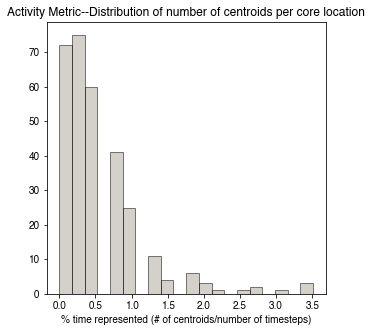

In [378]:
cent_xage = copy.deepcopy(cent_nonan[:, :2]) #create an array with only the centroid age and the rounded x location
cent_xage[:, 1] = np.round(cent_xage[:, 1], 0)

gappiness = np.empty([int(position.max()), 2]) #matrix to store the gappiness measure of the data
                                       #0-position (rounded) #1 = number of centroids at xpos
    
for i in range (0, int(position.max()), 1):
    gappiness[i, 0] = i
    gappiness[i, 1] = 100*len(np.where(cent_xage[:, 1]==i)[0])/end_t

fig, ax = plt.subplots(1, figsize = (5, 5))
distofages = ax.hist(gappiness[:, 1],  **kwargs)
ax.set_title('Activity Metric--Distribution of number of centroids per core location')
ax.set_xlabel('% time represented (# of centroids/number of timesteps)')
#plt.savefig(savefilesto+'stats/'+modelrun+'activity.png', dpi = 100)

## Load the reach width data

In [379]:
reach_raw = np.load(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/chan-widths/CW-{datnam}')
reach_raw = reach_raw[:, :, :num_timesteps]
## create array to store the statiistics on the channel width for the full reach 
## This is a end_t x 3 array with min, max and mean reach width
max_chw = reach_raw[:, 2].max(axis=0)
min_chw = reach_raw[:, 2].min(axis=0)
reach_raw = np.concatenate((reach_raw, np.empty([len(reach_raw), 1, end_t])), axis = 1)
print(reach_raw.shape)
for i in range (0, end_t-1):
    reach_raw[:, 3, i] = (reach_raw[:, 2, i+1]-reach_raw[:, 2, i])/interval_to_plot #find and append reach data with widening rate, PER HOUR
    

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/chan-widths/CW-0hfld-datamaster-1hour.npy'

In [ ]:
widths = xposition.max(axis = 1)-xposition.min(axis = 1)
times = np.arange(0, end_t*interval_to_plot, interval_to_plot)
rate = np.empty([end_t, 3])
rate[:] = np.nan

floodzone = mpl.patches.Rectangle((fldstart, widths.min()), fldlength/interval_to_plot, max_chw.max()-min_chw.min(), color = 'xkcd:sea blue', alpha = 0.1, label = 'Flooding')


for i in range(0, end_t-1):
    rate[i, 0] = (widths[i]-widths[i+1])/(times[i]-times[i+1])
    rate[i, 1] = reach_raw[:, 3, i].min()
    rate[i, 2] = reach_raw[:, 3, i].max()
    #print(rate[i])
fig, ax = plt.subplots(figsize = (10, 6), tight_layout = True)
ax.plot(times, widths, c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'section width')


ax.add_patch(floodzone)
ax.axvline(fldstart, c = 'xkcd:sea blue', ls = '--')
ax.axvline(fldstart+fldlength/interval_to_plot, c = 'xkcd:sea blue', ls = '--')
ax.fill_between(times, min_chw, max_chw, color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
ax2 = ax.twinx()
ax2.plot(times, thickness.max(axis = 1)/times, c = 'xkcd:black', ls = '--', marker='.', mfc = 'k', mec = 'k', mew = 0.3, label = 'Max thickness')
ax2.plot(times, thickness.min(axis = 1)/times, c = 'xkcd:steel grey', ls = '--', marker='.', mfc = 'xkcd:steel grey', mec = 'xkcd:steel grey', mew = 0, label = 'Min thickness')
ax2.plot(times, np.mean(thickness, axis = 1)/times, c = 'xkcd:cerise', marker='.', mfc = 'xkcd:cerise', mec = 'k', mew = 0, label = 'Mean thickness')

ax.set_ylim(min_chw.min(), max_chw.max())
ax.set_xlim(0, end_t)
ax.set_ylabel('Channel Width, m')
ax.set_xlabel('Timestep')
ax2.set_ylabel('Bed thickness, m')
plt.title('The question is: Will these trends hold for variable discharge')
ax.legend(loc = 'upper left')
plt.legend(loc = 'best')
#plt.savefig(savefilesto+'widths/'+modelrun+'.png', dpi = 100)

In [ ]:

fig, ax = plt.subplots(1, figsize = (10, 6))
ax.plot(times, rate[:, 0], 'r', ms = '5', mec = 'r', mfc = 'k', label = 'Section Widening Rate')
ax.fill_between(times, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
ax.axvline(fldstart*interval_to_plot, c = 'xkcd:sea blue', ls = '--', alpha = 0.5)
ax.axvline(fldstart*interval_to_plot+fldlength, c = 'xkcd:sea blue', ls = '--', alpha = 0.5)
ax.legend()
ax.set_title(f'Widening trends aong the reach compared to section at {iloc*cellL} m')
ax.set_ylabel('Widening Rate, m/hr')
ax.set_xlabel('Time, hr intervals')

plt.savefig(savefilesto+'widths/rate'+modelrun+'.png', dpi = 100)

In [ ]:
rate[~np.isnan(rate)].min()


## Group centroids by age and location 
My version of an okayish nearest neighbour regression

## EXTRACT MAIN BOUNDING SURFACES

### A overly wordy note on pervasive surfaces of erosion and non-depositon...

22/01/2021

(tl;dr) Skip to the 5th paragraph for the code logic, paragraphs 1-5 are sort of an amuse-bouche:

Okay, I spent the last coupe of weeks tinkering with different methods of picking out the mot pervasive/prominent/erosiva/longest non-depositional surfaces in the stratigraphy and it feels immensely complicated. I've tried multiple methods that are equally shitty, but some have their own advantages. 

In an ideal case, I'd be able to lot out entire, through-going and complete surfaces at each timestep that repesent the major bounding surfaces in the stratigraphy after the end of the entire model run. I have, to this date, never seen this done in a paper. The closest to this was the extracion of surfaces of erosion in Wietse Van de Lageweg's dissertation (Chapter 5, also published in 2014ish, its a sedimentology paper i think). Being able to pull out these surfaces is important becuse they most likely represent the best (quality and quantity) resolution of the internal evolution of the channel belt that we may be able to capture in the feld, so naturally, we would want to compare the model stratigraphy at this similar scale. 

The problem I'm having is that I only have piecemal locations of erosion and non-deposition that do not make complete surfaces on the plots, ergo I cannot create polygons (read: bar packages) to get various statistics from the model stratigraphy. No statistics == No thesis == Stuck in State College forever (only a little bit melodramatic here, if you are reading this and you are not Safiya, I apologise, unless you find this rant amusing. I hope you do. Sorry for the digression, anyway back to extracting the most prominent bar packges from the model stratigraphy...). In an ideal case I would be able to (and sorry this is essentially a figure so I am thinking like a graphic artist/GIS person here) plot all the piecemal erosion and hiatal surfaces on a plot that is technically 3D (x-y-time) as I plotted it using a for loop then flatten the plot onto only the x-y dimension, then I would have essentially a polyline (I think, idk what a polyline is tbh, but essentially I'd have a complex shape made up of multiple polygons..maybe I'll have a muiltipolygon idk) which I could transfer to another software package (maybe Petrel, Arc, Photoshop, ImageJ or something) and extract the dimesions and attributeds of the polygons, get my statistics and graduate (or publish, who know's what future Saf will do). There are two problems with this approach:

1. I do not know how to do that, and I worry that the exercise in figuring it out will literally take all of the power my two brain cells possess and take literally forever because I ain't no coder and have yet to find a comp scientist that can help with this problem in a *helpful* way. 
2. This mightn't even be beneficial because then we will have the same problem of assessing the universiality of image based statistical approaches to building statistics like this (re Ellen and Liz stick model avulsion problems with relating model space to field space) and all of my years of furious stack exchange searches will be a (comparative) waste
    
With this in mind, I am trying to adopt a vector-based, pseudo-statistical approach to figure put exactly which surfaces will statistically get preserved in outcrop (omfg I could literally write a paper on this but again I digress...). I've tried a couple ways to get this going in the cells that follow, using the array that stores the ages of all surfaces of the stratigraphy (ages_ero). This array accounts for resetting of the age of a deposit when it is eroded and also for when there is non-deposition (hiatus):

<u>Approach 1: </u> Non-normalised, high-frequency surfaces
In this method I plot the frequency of the ages of the aurfaces in the straitgraphy assuming that more pervasive and persistence surfaces will have higher frequencies. We want to then know what the distribution of frequencies looks like. Essentially we want the freuqncies that are the outliers, the things that are more frequent than anything else, these are, theoretially correspodent to erosion surfaces that rework the most stratigraphy or hiatal surfaces that receive no deposition for the longest time. When building the aes_ero matrix, these are the surfaces that get reset the most therefore should have an inordinately high frequency. I then create set of quantiles that we want (that in this case specify te degree of eworking/non-depositing at the surface), for this case I use the 75th, 80th, 85th and 90th. I plot the ages (read: timesteps) that correspond to those quantiles, and compare the resultant stratigraphy to that which is output when I plot the erohiatalsurfs only. This method is ok, however it doesn't cover some of the earlier surfaces since either (1) the 'area' that is available to be reworked at a time is much less than that available at a later time, say comparing erosion at timestep 25 having '25 x posnew' number of locations for erosion vs timestep 200 with '200 x posnew' locations to erode (assuming even deposition everyhere between those time maybe. I'm hoping you understand how this might be problematic. But somehow it kinda works, it seems like consistently, surfaces above the 85th ish percentile best for the erohistalsurf surfaces, which is interesting. 

<u>Approach 2: </u> Normalised, high-frequency surfaces
This is the same method as Approach 1 except I normalise the Frequency of ages in the ages_ero matrix to the area available for erosion at each timestep. Theoretically this would give us a more representative distribution of the most erosive surfaces but so far it just skewes the histogram to the left (aggressively) and almost all of the surfaces become insignificant (excl the initial surface and the final one)

<u>Approach 3: </u>Most continuous erosion surfaces
Here I found the count of the number of points of erosion/non-deposition at each timestep with the hypothesis that the surfaces that were the most pervasive and persistent were the ones that resampled the most stratigrahy therefore the count of non-nan elements in the array should be highest in the important surfaces (again using quantiles). There are a couple problems with this but the most significant is that erosion surfaces are not always the same age  so when you sum the non-nan elements it's not entirely an accurate representation and it isqute unlikely that a surface across the entire cross section is an erosion surface, meaning that we get alo the bits of the surface that are depositonal and that does not help in further defining the packages. 

These all suk, but I think Approach 1 is the best so far, at 85th percentile. I have to find the right way to normalise for Approach 2 because theoretically it should be the most ideal method of the 3. 

## Update 25/01
I think the 50th quantile (median) using te corrected version of approach 2 (v2, new UP 25/01) is the best at pulling out the erosion surfaces most accurately with the least 'extra' surfaces that make the resolution finer than what we seee in the field. 

## LOL JOKES 03/02
The previous statement was only true for like one cross section. The EH count approach (approach 3) seems to be effective-est for now

## EH Count method (rooted in approach 3)
So far the method of finding the surfaces that reworked > x frac of surf is the best
3 Feb 2021

Here we find the number of points of erosion and hiatus on each surface (Erocount) then find the fraction of the surface that is reworked

In [ ]:
erocount = np.empty([end_t, 3]) #holding the count of non-nan elements to identiy major erosion/hiatal surfs

for row in range (0, end_t):
    length = int(np.floor(xposition[row, -1]-xposition[row, 0])) #length of the section at time, t
    
    erocount[row, 0] = row #timestep value
    endpos = int(xposition[row].max())
    startpos = int(xposition[row].min())
    #print(endpos)
    erocount[row, 1] = np.count_nonzero(~np.isnan(erohiatalsurf[row, startpos:endpos])) #count number of EH surfs
    erocount[row, 2] = erocount[row, 1]/length #fraction of surf EH reworked
    #print(row, length, erocount[row, 1],length-erocount[row, 1])
    #print(erocount.shape)

plt.hist(erocount[:, 2], bins = 10)

## Another Friday, another ramble about percentiles:

So, right now I'm using (today is Feb 5th 2021 btw) a 'propoerion of bed surface reworked' type approach to find the main erosional and hiatal surfaces in the stratigraphy. The fundamental tenet here is that the most 'boundy' bounding surfaces will be he surfaces that have had the longest times of non-deposition or the most erosion, ie. I'm assuming that the stratigraphy is made up of deposition along the most active reworking surfaces. 

Do the method I employ to do this is to find the sum of locations across the section, at each timestep, that undergo hiatal or erosion events and represent that as the fraction of the bed that is reworked. Then, I find, from the distribution of these fractions, the nth percentile, my threshold for what is major vs minor. To check to find which percentile is the 'best' percentile, I have a nifty little loop that basically tests the stratigraphy/main surfaces output at each percentile against the true erohiatalsurf array for similarity. 

My rule for similarity is as follows: *the percentiles that produce the best stratigraphy will be the percentiles where (1) as many unique elevation points are incorporated into the bounding surface array as possible and (2) as little true erosion data are deleted*. This 2nd rule requires then, that the number of elements in the bounding surface array cannot be less than the number of elements in the erohiatal array, which is why, as you'll see, the percentile value is so low-I'm leaving in a lot of extra stratigraphy to make sure that this statistical stratigraphy I develop is as faithful to the actual erohiatal data as possible. 

As you'll see, we end up with a lot of extra surfaces that are likely unresolveable in the field, much like the hiatal situation. I think it's fair to say that for a 100m wide outcrop, we will not be able to resolve bars/mar kinematics that are less than ~2cm thickness, so I removed any surface that aggrades by less than that, kind of like how those folks remove surfaces for dunes...maybe ths is something worth checking out. I think the Van Rijn literature cites that the scaling/removal relationship for sub-bar scale topography is 0.3 x flowdepth dune scale)...what I'm getting at is that for my ~0.8m flow depths, remooving 2cm of topography is a non-issue.  

As you will see, this method produces a very nice estimation of the EH stratigraphy, with much of the small scale topography removed. I think, for my efforts and the value of this piece, this method will suffice and I am moving on to statistics headaches. 

In [ ]:
threshperc = np.arange(50, 100) #range of percentiles to test the fir over
coverage = np.empty([1, len(posnew)])

for i in threshperc:
    thresh_frac = np.percentile(erocount[:, 2], i) #fraction of surface we want reworked to call it a major surface
    big_times = erocount[np.where(erocount[:, 2] >= thresh_frac), 0]
    big_times = big_times.ravel()
    print(len(big_times))
    bounding_surfaces = np.empty([1, len(posnew)+1]) #will store coordinates of main bounding surfaces plus the time of the surface
    bounding_surfaces[:] = np.nan


    for t in big_times:
        t = int(t)
    #ax[0].plot(posnew, stratinterpcub[i, :], c='w', lw=1.5)#, color = cpick.to_rgba(i), lw = 1.5)
        #pull true topography
        boundscratch = np.append(t, xy_topo[t, :])
        bounding_surfaces = np.append(bounding_surfaces, np.reshape(boundscratch, [1, len(posnew)+1]), axis=0)


    dummymatrix = np.empty_like(xy_topo)

    dummymatrix[:] = np.nan
    
# dont nee dummy matrix
    #count all non nan elements, subtract elements in the first column
    num_elements = np.count_nonzero(~np.isnan(bounding_surfaces))-len(bounding_surfaces)+1
    #num_elements = np.count_nonzero(~np.isnan(erohiatalsurf))
    #print(num_elements, len(bounding_surfaces))
    for column in range (1, len(posnew)): #search corewise across the section
        uniquebounds = np.unique(bounding_surfaces[:, column][np.where(~np.isnan(bounding_surfaces[:, column]))]) #search bounding surfaces
        unique_eh_bounds = np.unique(erohiatalsurf[:, column-1][np.where(~np.isnan(erohiatalsurf[:, column-1]))]) #search erohiatal surfaces
        #uniquebounds = np.delete(uniquebounds, np.nan)
        #unique_eh_bounds = np.delete(unique_eh_bounds, np.nan)
        #print(uniquebounds, unique_eh_bounds)
        #print(np.intersect1d(uniquebounds, unique_eh_bounds))
        coverage[0, column] = len(np.intersect1d(uniquebounds, unique_eh_bounds))
    
    totalcoverage = np.sum(coverage) #total overlap of the two arrays
    total_coverage_frac = totalcoverage/num_elements

    
    if num_elements < np.count_nonzero(~np.isnan(erohiatalsurf)):
        break
print('Best percentile = ', i, '. Coverage = ', total_coverage_frac)
bestperc = i

In [ ]:
np.count_nonzero(~np.isnan(erohiatalsurf[1, :]))

In [ ]:
## look at what removing some different threshold thicknesses will do to the data

fig = plt.figure()

bd_surfs = np.empty([1, len(posnew)+1])
#print(fnl_surfs)

for i in range(2, bounding_surfaces.shape[0]):
    x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :])
    #print(x)
    
    plt.plot(i, x, 'ro')
plt.axhline(np.percentile(thickness, 70))    
fig, ax = plt.subplots(4, 1, figsize = (5, 5), tight_layout = True, sharex = True)
for i in range (0, 3):
    for j in range (0, end_t):
        ax[i].plot(posnew, erohiatalsurf[j, :], 'k',  lw = 3, alpha = 0.7)

mean_thickness_threshold = np.array([0.01, 0.02, 0.03])
for i in range(1, bounding_surfaces.shape[0]): ## bounding_surfaces row 0 is a row of nans, start from 2
    x = np.nanmean(bounding_surfaces[i, :]-bounding_surfaces[i-1, :]) #check to see hpw much sediment added at that time

    if x > 0.00:
        ax[0].plot(posnew, bounding_surfaces[i, 1:])
        
    if x > mean_thickness_threshold[1]:
        ax[1].plot(posnew, bounding_surfaces[i, 1:])
        ax[1].set_title('Threshold = '+str(mean_thickness_threshold[1]))
    if x > mean_thickness_threshold.max():
        ax[2].plot(posnew, bounding_surfaces[i, 1:])
        ax[2].set_title('Threshold = '+str(mean_thickness_threshold.max()))
        bd_surfs = np.append(bd_surfs, np.reshape(bounding_surfaces[i, :], [1, len(posnew)+1]), axis = 0)
        
    #if x < 0.03:
        #print(i)
        

#print(fnl_surfs[0, :])
fnl_surfs = bd_surfs


#print(fnl_surfs[0, :])
print(bounding_surfaces.shape, bd_surfs.shape, fnl_surfs.shape)
print('number of surfaces deleted = ', (bounding_surfaces.shape[0]-1)-fnl_surfs.shape[0])

for i in range (0, len(fnl_surfs)):
    ax[3].plot(posnew, fnl_surfs[i, 1:])
ax[3].set_title('Final surfaces matrix')
ax[-1].set_xlim(0, posnew.max())

In [ ]:
print(fnl_surfs[0,0])

In [ ]:
#np.save(f'/Volumes/SAF_MSCWORK/Python/Stratigraphy/Data/nparrays/mainsurfs/{mainsurfto}/'+modelrun, fnl_surfs)

## Coring the *new* stratigraphy

I am too lazy to really change the names of things that much so Imma prefix all the copied variables with 'bs'...for 'bounding surfaces'....not bullshit. 

In [ ]:
bs_coresthick = {} #dictionary to hold set thickness
bs_coresbounds = {} #dictionary to hold bound surfaces
bs_num_sets = np.empty([len(posnew), 2])
bs_num_sets[:, 0] = posnew
bs_threshold = 0.1
for i in range(0, len(posnew)):
    keystr = 'x'+str(i)
    
    elevatcore = fnl_surfs[:, i+1]
    bounds = np.unique(elevatcore)
    
    bs_coresbounds[keystr] = bounds #finds the bounding elevations of sets
    
    diffs = np.empty([0]) #temp array to store thickness of sets > a threshold thickness
    
    for j, k in zip(bounds[:-1], bounds[1:]):
        #print(i, j, k)
        diff = k-j #more positive -- less positive = positive
        if diff > bs_threshold:
            diffs = np.append(diffs, diff)
    bs_coresthick[keystr] = diffs
    bs_num_sets[i, 1] = len(diffs)
    
    #print(cores[keystr+'_thick'])
#print(cores)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4), tight_layout=True)
ax[0].plot(bs_num_sets[:, 0], bs_num_sets[:, 1], 'k', label = 'Main Surfaces extract')
ax[0].plot(num_sets[:, 0], num_sets[:, 1], 'k--', alpha = 0.7, label = 'True EH surfaces')
for i in range (0, end_t):
    #ax[1].plot(posnew, stratinterpcub[i], 'k', lw = 0.1, alpha = 0.4)
    #ax[1].plot(posnew, erosurf[i], 'r', lw = 2)
    #ax[1].plot(posnew, hiatalsurf[i], 'g', lw = 2)
    ax[1].plot(posnew, erohiatalsurf[i], 'r', lw = 2)
for i in range (0, len(fnl_surfs)):
    ax[1].plot(posnew, fnl_surfs[i, 1:], 'k', lw = 0.5)

for i in range(0, len(posnew)):
    ax[1].axvline(posnew[i], c = 'k', ls = 'dotted', lw = 0.3)
    ax[0].axvline(posnew[i], c = 'k', ls = 'dotted', lw = 0.3)
ax[1].set_ylabel('Bed Elevation, m')
ax[0].set_ylabel('Number of Sets')
ax[1].set_xlabel("Cross Stream Position")
ax[0].set_xlabel("Cross Stream Position")
ax[0].legend()
ax[0].set_ylim(0, 15)

ax[0].set_title('Time series of number of sets at iloc = '+str(iloc))
ax[1].set_title('Stratigraphy at '+str(iloc)+'. Ero = red, Hiatal = green')
#plt.savefig(savefilesto+'corestats/compare'+modelrun+'.png', dpi = 100)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (14, 4), tight_layout = True)
ax[0].plot(bs_num_sets[:, 0], bs_num_sets[:, 1], 'k')
ax[0].set_title('Number of sets along the section')

for loc, core in zip(posnew, bs_coresthick):
    avg = np.average(bs_coresthick[core])
    #print(coresthick[core], avg)
    if len(bs_coresthick[core]) >0:
        ax[1].plot(loc, np.average(bs_coresthick[core]), 'o', markerfacecolor = 'b', markeredgecolor = 'k')
        ax[2].plot(loc, bs_coresthick[core].max(), 'o', markerfacecolor = 'g', markeredgecolor = 'k')
        
ax[2].set_ylim(0, 2)
ax[1].set_ylim(0, 2)

ax[2].set_title('Maximum set thickness at each cor loc')
ax[1].set_title('Average set thickness at each cor loc')

fig.suptitle(str(iloc))

plt.savefig(savefilesto+'/corestats/'+modelrun+'.png', dpi = 100)

In [ ]:
allthick_der = np.array([])
allthick_eh= np.array([])
plt.figure(figsize = (10, 6))
#print(allthicknesses_derived.shape)
for key1, key2 in zip(bs_coresthick, coresthick):

  #print(bs_coresthick[key])
  allthick_der = np.append(allthick_der, bs_coresthick[key1])
  allthick_eh = np.append(allthick_eh, coresthick[key2])
  
hist2 = plt.hist(allthick_der, **kwargs, density =True,label = 'Main Surfaces extract')
  
hist = plt.hist(allthick_eh, histtype='step', density=True, edgecolor = 'k', linewidth = 2.5, bins= 20, label='True EH thicknesses')
  
plt.legend()
plt.ylabel('Normalised Frequency')
plt.xlabel('Vertical Set Thickness, m')
plt.title('Distribution of core thicknesses of sets')

def find_percentiles (age_array, ptilestart, ptilestop, ptileint):
    
    
    #create the frequency array
    
    hist, bins = np.histogram(age_array.ravel(), bins = end_t) #find frequency of all ages in stratigraphy
    hist = np.reshape(hist, [num_timesteps, 1])
    age_dist = np.reshape(np.arange(0, num_timesteps), [num_timesteps, 1]) 
    frequencies = np.append(age_dist, hist, axis = 1) #frequency of each timestep in the stratigraphy
    
    #declare the percentile range you want to test fit to
    ptiles_to_test = np.arange(ptilestart/100, ptilestop/100, ptileint/100)
    #print('get ptiles', ptiles_to_test.shape)
    ptile_vals = np.quantile(frequencies[:, 1], ptiles_to_test)
    #print('ptilevals', ptile_vals.shape)
    
    best_intersect = 0.0000 #pace holder for best value of intersection across the percentiles
    best_ptile = 0 #placeholder for best percentile value
    
    for val in ptile_vals:
        #print(val)
        ## make new array to store main surfaces
        main_surfs_age = np.empty_like(erohiatalsurf) 
    
        ero_idx = np.where(frequencies[:, 1] > val) #find which ages exceed the percentile value youre testing
        #print('ero_idx', ero_idx)
        target_ages = frequencies[:, 0][ero_idx] #fidnthe ages that correspond tp the value
        #print('ages', target_ages)
        for age in target_ages:
            main_surfs_age[age, :] = stratinterpcub[age, :]
            
        find_intersections = np.where(main_surfs_age == erohiatalsurf)
        #print(find_intersections)
        num_intersect = len(find_intersections[0])/(len(erohiatalsurf.ravel()))
        #print('number of intersections', num_intersect)
        if num_intersect > best_intersect:
            best_intersect = num_intersect
            best_ptile = ptiles_to_test[np.where(ptile_vals ==val)]
    #print(best_intersect, best_ptile)
    return('Best percentile: ', best_ptile, 'Intersection value:', best_intersect)#, 'Percentile vals:', ptile_vals)
        
    
    

find_percentiles(ages_ero, 75, 100, 1)

#main_surfs.shape

## Grouping centroids by their spacing

In [ ]:
centroids = np.append(cent_nonan, np.zeros([len(cent_nonan), 1]), axis=1)
hoods = np.empty([1, 3]) #will hold the neighbourhoods the centroids could fall into and the age of the centroid
hoods[0] = centroids[0, :3]

thresh = np.median(dists) #50 #distance threshold to call it a neighbour
print('ICD Threshold is: ', thresh)
for i, age in zip(range(1, len(centroids)), centroids[1:, 0]):
    #print('*******age: ', age, '******** i: ', i)
    potential_hoods = hoods[np.isclose(hoods[:, 0], age, atol=2)]
    
    #print('I: ',i, ' age: ', ' hood: ', potential_hoods)
    if len(potential_hoods) == 0:
        hoods = np.append(hoods, np.reshape(centroids[i, :3], [1, 3]), axis=0) #create new hood with cent x, y and age
        centroids[i, -1] = centroids[i, 0] #add new hood zipcode zipcode column (last column)
        print('no existing hood is good, new hood ->', hoods.shape)
    else: 
        potential_hoods = np.reshape(potential_hoods, [len(potential_hoods), 3])    
        #print(i, potential_hoods)
        #print(potential_hoods.shape)
        #print(np.where(np.isclose(hoods[:, 0], age, atol=5)))
        #potential_hoods = np.resha
        #print('ph', potential_hoods)
        distances = np.array([])
    
    
        #test each potential hood for distance
        for row in potential_hoods:
        
            dist = ((centroids[i, 1]-row[1])**2 + (centroids[i, 2]-row[2])**2)**0.5
            distances = np.append(distances, dist)
        #print('dist shape', distances.shape, )
            #find nearest neighbour, append or make ner neighbourhood
    
        mindist = distances.min() #ifind minimum calculated distance between point and all potential neighbours
        potenti = potential_hoods[np.where(distances==mindist)]
        #print('potenti shape: ', potenti.shape)
        #print('Mini dist: ', mindist,'potential neighbourhoods: ', potenti)
        #print(distances)
        if (mindist < thresh) & np.isclose(potenti[:, 0], age, atol=2): 
            md_hood = np.where((hoods[:, :3] == potenti).all(axis=1))
            #print('equal at: ', md_hood)
            hoods[md_hood, 1:] = potenti[:, 1:]
            centroids[i, -1] = hoods[md_hood, 0]
            #print(centroids[:i+1, -1])
        elif mindist > thresh:
            hoods = np.append(hoods, np.reshape(centroids[i, :3], [1, 3]), axis=0)
            centroids[i, -1] = centroids[i, 0]
            print('Too far from everything, make new hood, it = ', i, hoods.shape)

In [ ]:
fig = plt.figure(figsize = (10, 4), tight_layout = True)
for i in range(0, len(centroids)):
    plt.plot(centroids[i, 1], centroids[i, 2], color = cpick.to_rgba(centroids[i, -1]), marker = 'o')
for i in range (0, end_t):
    plt.plot(erohiatalsurf[i], 'w', alpha = 0.2)
ax = plt.axes()
ax.set_facecolor('xkcd:midnight blue')

In [ ]:
##look at/calculate residence time/reworking tme 
fig = plt.figure(figsize = (10, 3))
numneighbs = collections.Counter(centroids[:, -1])
plt.stem(numneighbs.keys(), numneighbs.values())
plt.title('Stem Plot of size of Neighbourhoods \n possible proxy for degree of persistence?');
plt.xlabel('Neighbourhood Zip Code')
plt.ylabel('Number of deposits \n in neighbourhood')
neighb_list = collections.Counter(centroids[:, -1]).most_common()
print(neighb_list)

**This is just a check to see if the neighbourhood code works correctly** <br> Pick a neighbourhood and plot the centroids in that neighbourhood and the ages of the centroids in that neighbourhood.

In [ ]:
tn = 107 #test neighbourhood number
intn = centroids[:, 0][centroids[:, -1]==tn].astype('int')
plt.plot((centroids[:, 1][centroids[:, -1]==tn]), (centroids[:, 2][centroids[:, -1]==tn]), '.')
for i in intn:
    plt.plot(posnew, xy_topo[i], 'k', lw = '0.1')

In [ ]:
hmm = np.unique(centroids[:, -1]).astype(int)
for i in hmm:
    plt.plot(xy_topo[i])

##plot length of centroid groups with time compared to widening rate
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 15), tight_layout = True)
#ax.plot(times, widths, c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'channel widening')
#floodzone = mpl.patches.Rectangle((fldstart, rate.min()), fldlength, rate.max()-rate.min(), color = 'b', alpha = 0.1, label = 'Flooding')



ax1.plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax1.set_ylabel('Channel Widening Rate, m/timestep')
ax1.set_title('Widening and group width')

ax2.plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax2.set_ylabel('Channel Widening Rate, m/timestep')
ax1.set_title('Widening and group height')

ax3.plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax3.set_ylabel('Channel Widening Rate, m/timestep')
ax1.set_title('Widening and group W:H')

ax4.plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax4.set_ylabel('Channel Widening Rate, m/timestep')
ax1.set_title('Widening and bed elevation change')

ax1.fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
ax2.fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
ax3.fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')
ax4.fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')


ax4.set_xlabel('Timestep')
ax1.xaxis.grid(True)
ax5 = ax1.twinx()
ax6 = ax2.twinx()
ax7 = ax3.twinx()
ax8 = ax4.twinx()
#ax3 = ax.twinx()
for key in groups:
    #print(cent_nonan[groups[key], 1].max(), cent_nonan[groups[key], 1].min())
    #print(cent_nonan[groups[key], 2].max(), cent_nonan[groups[key], 2].min())
    t = int(cent_nonan[groups[key][0], 0])
    tsi = np.where(cent_nonan[:, 0]==t)#time of group
    ts = tsi[0]
    #tmax = cent_nonan[groups[key][-1], 0] #time of group
    #grp_num = len(groups[key]) #how many packages in the group
    length = abs(cent_nonan[groups[key][-1], 0]-cent_nonan[groups[key][0], 1]) #length of time epresented in package, duration, timesteps
    width = cent_nonan[groups[key], 1].max()-cent_nonan[groups[key], 1].min() #width, m of package
    height = cent_nonan[groups[key], 2].max()-cent_nonan[groups[key], 2].min() #height, m of package
    #print(width, height, length, t)
    ax5.plot(t, width, 'x', mew = 2.5, c = 'k')#, color = cpick.to_rgba(cent_nonan[int(t), 0]))
    ax6.plot(t, height, '^', mew = 2.5, c='k')# color = cpick.to_rgba(cent_nonan[int(t), 0]))
    ax7.plot(t, (width/range_x)/(height/range_y), 'o', mew = 2.5, c = 'k')# color = cpick.to_rgba(cent_nonan[tsi, 0]))
    #ax3.plot(t, height, '^', mew = 2.5, color = cpick.to_rgba(cent_nonan[int(t), 0]))
    #ax.set_xlabel('Package width, m')

deltaelev = np.nanmax(xy_topo, axis = 1)-np.nanmin(xy_topo, axis = 1)
ax8.plot(times/2, deltaelev, '+', label = 'min-max')
ax8.plot(times/2, np.nanmean(xy_topo, axis = 1), '.', label = 'mean')
ax8.legend()


#ax1.add_patch(floodzone)
#plt.savefig(savefilesto+'centstats/'+modelrun+'.png', dpi = 100)

#### Some more bed elevation plots

In [ ]:
coev_bedelev = stats.variation(strat, axis = 1, nan_policy='omit') ##gives wonky values, using SD because it is normalised to N and the mean also
sd_bedelev = np.nanstd(strat, axis = 1)
fig, ax = plt.subplots(2, figsize = (12, 8), tight_layout = True)

ax[0].plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax2 = ax[0].twinx()
#ax2.plot(times/2, sd_bedelev, 'k.', label = 'SD Bed Elev')
ax2.plot(times/2, coev_bedelev, 'k.', label = 'CV Bed Elev')
ax[0].fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')

ax[0].set_ylabel('Channel Widening Rate, m/timestep')
ax[0].set_title('Widening and SD of bed elevation')

ax[0].legend(loc='right')
ax2.legend(loc = 'best')

#ax[0].axvline(fldstart, c = 'b', ls = '--')
#ax[0].axvline(fldstart+fldlength/interval_to_plot, c = 'b', ls = '--')

ax[1].set_title('Distribution of bed elevations before and immediately after flood \n Inset showing bed elevation pre and post flood')
axins = inset_axes(ax[1], width=3, height=1)
ax[1].hist(strat[pref_idx, :], **kwargs, label = 'Pre-Flood Hist')
ax[1].hist(strat[post_idx, :], histtype = 'step', bins = 20, lw = 2, ec = 'k', label = 'Post-Flood Hist')

axins.plot(strat[pref_idx, :], c = 'xkcd:greyish')
axins.plot(strat[post_idx, :], c = 'b')
axins.set_ylabel('Bed Elev')
axins.set_xlabel('XSD, m')

ax[1].set_ylabel('Count')
ax[1].set_xlabel('Bed Elevation, m')
ax[1].legend(loc='upper left')

plt.savefig(savefilesto+'centstats/WSD'+modelrun+'.png', dpi = 100)

In [ ]:
plt.subplots(figsize = (10, 4), tight_layout = True)

plt.plot(times/2, np.nanmin(shear, axis = 1), c = 'xkcd:grey', marker = 'v', lw = 0.0, label = 'Min shear')
plt.plot(times/2, np.nanmax(shear, axis = 1), c = 'b', marker = '^', lw = 0, label = 'Max shear')
plt.plot(times/2, np.nanmean(shear, axis = 1), c = 'k', marker = '.', lw = 0, label = 'mean shear')
plt.axvline(fldstart, c = 'b', ls = '--')
plt.axvline(fldstart+fldlength/interval_to_plot, c = 'b', ls = '--')

plt.plot(times/2, rate[:, 0], 'r--')
plt.ylabel('Bed Shear Stress, Nm/2')
plt.xlabel('Timestep, 2hour')
plt.title('Comparison between bed shear stress and channel widening rate \n null--widening and shear stress drops should occur together')
plt.legend()
plt.savefig(savefilesto+'centstats/SSvW'+modelrun+'.png', dpi = 100)

# If we want to accurately compare the reach statistics to the channel section, we need to be comparing the reach data

So for centroid mapping and statistics on the final stratigraphy, we need to be looking at this code with the xy_topo data but for true comparison and building these types of time series on the bed statistics, we need to be using the datamaster, not the xy_topo because that preserves only the final data

But actually, maybe we can use strat because strat is uneroded.... Yes, we can use strat.

In [ ]:
coev_reach = stats.variation(datamaster[:, 7, :], axis = 0)
sd_reach = np.std(datamaster[:, 7, :], axis = 0)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6), tight_layout=True)

ax.plot(rate[:, 0], c = 'r', ls = '--', marker='.', mfc = 'r', mec = 'k', mew = 0, label = 'rate')
ax2 = ax.twinx()

ax.fill_between(times/2, rate[:, 1], rate[:, 2], color = 'xkcd:stone', alpha = 0.3, label = 'Min/Max of reach')

ax.set_ylabel('Channel Widening Rate, m/timestep')

ax2.plot(times/2, coev_bedelev, 'k.', label = 'CV of x section')
ax2.plot(times/2, coev_reach, '.', c = 'xkcd:grey', label = 'CV of entire model domain', alpha = 0.5)

ax2.set_xlabel('timesteps (2 hours)')
ax2.set_ylabel('CV')
plt.title('CV bed elev of reach compared to XS')
plt.legend()

ax.axvline(fldstart, c = 'b', ls = '--')
ax.axvline(fldstart+fldlength/interval_to_plot, c = 'b', ls = '--')
#ax2.set_ylim(0, 1.5)

axins1 = inset_axes(ax, width=3.5, height=1.5, loc ='upper left')
axins1.plot(times/2, np.nanmean(xy_topo, axis = 1), 'k--')
axins1.plot(times/2, sd_bedelev, 'b--')

## Code to make gif animations of the strat infil, clunky

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4), dpi = 200)
ax.set_xlim(position.min(), position.max())
ax.set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo))

camera = Camera(fig)
#runtime = runtime+1-(runtime%10)
for age in range (end_t-1):
    for ts in range(0, age):
        ax.plot(xy_topo[ts], color = cpick.to_rgba(ts))
    fill = ax.fill_between(posnew, xy_topo[age+1], xy_topo[age], color=cpick.to_rgba(age), alpha = 1)
    ax.plot(posnew, xy_topo[age], 'k', alpha = 0.5)
    ax.plot(posnew, xy_topo[age+1], 'k', alpha = 0.5)

    
    camera.snap()
    #ax.clear()
animation = camera.animate()  
animation.save(f'{savefilesto}gifs/{modelrun}fill.gif', writer = 'imagemagick')

fig, ax = plt.subplots(figsize = (10, 4), dpi = 200)
ax.set_xlim(position.min(), position.max())
ax.set_ylim(np.nanmin(xy_topo), np.nanmax(xy_topo))

camera = Camera(fig)
#runtime = runtime+1-(runtime%10)
for age in range (0, end_t-1):
    pre, = ax.plot(strat[age], color = cpick.to_rgba(age))
    pre.remove()
    #ax.clear()
    for ts in range(1, age):
        ax.plot(xy_topo[ts], color = cpick.to_rgba(ts))
    fill = ax.fill_between(posnew, xy_topo[age+1], xy_topo[age], color=cpick.to_rgba(age), alpha = 1)
    ax.plot(posnew, xy_topo[age], 'k', alpha = 0.5)
    ax.plot(posnew, xy_topo[age+1], 'k', alpha = 0.5)

    
    camera.snap()
    #ax.clear()
animation = camera.animate()  
#animation.|save(f'{savefilesto}gifs/{modelrun}fill.gif', writer = 'imagemagick')
animation.save(f'/Users/safiya/Desktop/{modelrun}fill.gif', writer = 'imagemagick')

In [ ]:
plt.plot(strat[0])

packages = np.empty([1, 1, 1])
fig, ax1 = plt.subplots(1, 1, tight_layout=True, squeeze=True)#, figsize=(19.80, 10.8))

polyCollection = ax1.fill_between(posnew, stratinterpcub[0], stratinterpcub[1], color=cpick.to_rgba(0), alpha = 1)
points = polyCollection.get_paths()[0].vertices #get vertices from the fill polygons
poly = Polygon(points) #convert vertices to polygon
#print(points)
#mpoly = Polygon(points)

#polygon_store = {'polygon 0':{'age': 0, 'verts':poly, 'patch': PolygonPatch(poly)}}
polygon_store = {'polygon 0': poly}#, 'patch 0':patch}

for age in range (0, end_t-1):
    polyCollection = ax1.fill_between(posnew, stratinterpcub[age+1], stratinterpcub[age], color=cpick.to_rgba(age), alpha = 1)
    points = polyCollection.get_paths()[0].vertices
  
    poly = Polygon(points) #make vertices a polygon
    polystring = "polygon "+str(age)
    patchstring = "patch "+str(age)
    polygon_store[polystring] = poly #create key in dictionary 'polygon_store' which holds the vertices of the polygon at 'age'
    

fig, ax = plt.subplots(1, figsize = (5,5))

for i in range (0,10):
    #fig, ax = plt.subplots(1, figsize = (10, 10))
    namestring = "polygon "+str(i)
    patch = PolygonPatch(polygon_store[namestring])
    ax.add_patch(patch)

ax.set_xlim(0, 18)
ax.set_ylim(stratinterpcub.min(), stratinterpcub.max())

fig, ax = plt.subplots(figsize = (12, 4), tight_layout = True, dpi = 400)
#data = ax.contourf(xdomain, ydomain, elev, levels = 500, cmap = 'gist_earth')
def animate(i):
    ax.plot(posnew, deposurf[i], 'xkcd:midnight blue', ls = '--', lw = 0.8, alpha = 0.3)
    ax.fill_between(posnew, stratinterpcub[i+1], stratinterpcub[i], color=cpick.to_rgba(i), edgecolor = 'xkcd:midnight blue', lw = 1, ls = '--', alpha = 1)
    ax.plot(posnew, erohiatalsurf[i], 'xkcd:midnight blue', lw = 1.5, alpha = 1)
    
    cent_loc = np.where(cent_array[:, 0]==i)
    ax.plot(cent_array[cent_loc, 1], cent_array[cent_loc, 2], marker = '.', markerfacecolor = 'k', markeredgecolor = 'k', mew = .1,   ms = 4, alpha = .5)
    ax.set_facecolor('xkcd:grey')

    ax.set_ylim(stratinterpcub.min(), stratinterpcub.max())
    #ax.set_xlim(1000, 2000)
    ax.set_title('Time = '+ str(i*10)+ ' min') 
    ax.set_xlabel('Streamwise Distance, m')
    ax.set_ylabel('Bed Elevation, m')


interval = 0.02#in seconds     
ani = animation.FuncAnimation(fig, animate, num_timesteps-1, interval=interval*1e+3, blit=False)
#FFwriter = animation.FFMpegWriter()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

ani.save(savefilesto+'Videos/'+modelrun+'.mp4', writer = writer)
#plt.show()

## Make the bed set thickness time series plots.
xloc = np.random.choice(int(position.max()), 4, replace = False)
print(xloc)
fig, ax = plt.subplots(1, len(xloc), figsize = (16, 4), tight_layout = True)

for xloc, i in zip(xloc, np.arange(0, len(xloc))): 
    ax[i].plot(age_dist, topointerp[:, xloc], 'k')

    sets = np.sort(topointerp[:, xloc])

    ax[i].axhline(sets[0], c = 'r', ls = '--', lw = 0.5)
    #ax[i].axhline(sets[-1], c = 'r', ls = '--', lw = 0.5)
    #ax[i].axhline(sets[2], c = 'r', ls = '--', lw = 0.5)
    #ax[i].axhline(sets[3], c = 'r', ls = '--', lw = 0.5)
    ax[i].set_title(str(iloc)+' elevation time series @'+str(xloc))
    
plt.savefig('/content/gdrive/My Drive/Python/Stratigraphy/Plots/elevtimeseries/'+modelrun+'.png', dpi = 100)

## APPROACH 2-v1 (legacy, placed as markdown because I think the counting algorithm is wrong)
I do not think this normalising thing is working because we get a gigantically skewed histogram of normalised ages that make it difficult to pull out the main surfaces but I think with the improvements in the hiatal pick-out-ing we get a more even spread of age data

fig, ax = plt.subplots(1, 2, figsize = (12, 6), tight_layout = True)
allages = ages_ero.ravel()
age_hist, bins = np.histogram(allages, bins = end_t) #gets frequency of alhow l ages
age_hist = np.reshape(age_hist, [num_timesteps, 1])
age_dist = np.reshape(np.arange(0, end_t), [end_t, 1]) #a column vector of all of the number of timesteos

#normalising time of erosion to area available for erosion with Liz 14/01

erodible_area = 200*age_dist # finding the area available to erode
area_norm = np.divide(age_hist, erodible_area) #normalising area resampled to area available to be resampled 
area_norm[0] = 0
#age_norm = np.delete(age_norm, 0, axis = 0)
#plt.hist(age_norm)
normalising = np.concatenate((age_hist, erodible_area, area_norm), axis = 1) #column vector of frequencies of ages 
                                                                        #(i.e. area reworked)[0], area avail to rework [1]
                                                                        # and the normalised area/reworking time [2]
#print(normalising)

#ax[0].plot(age_dist, area_norm) #plot the series showing the area resampled normalised to the area available for resampling
#ax[0].plot(age_dist[1:], age_hist[1:])
#ax[0].set_ylim(0, area_norm.max())
norm_area_hist, bins = np.histogram(area_norm, bins = num_timesteps) #gets frequency of ages, normalised to the area available for reworking
norm_area_hist = np.reshape(norm_area_hist, [num_timesteps, 1])

#frequencies = np.append(age_dist, hist, axis = 1)
frequencies = np.append(age_dist, norm_area_hist, axis = 1) # becuase we want the frequencies of the normalised age/areas from which we can find the most frequent

print(np.percentile(frequencies, 10))


print(frequencies.shape)

ax[0].hist(area_norm, bins = num_timesteps)
ax[1].hist(norm_area_hist, bins = 50) #frequency of frequencies
ax[0].set_title('Vol Resampled, normalised to area')
ax[1].set_title('Freq Distribution of amount of Vol Resampled')

want_quants = np.array([0.25, 0.50, 0.75, 0.90])
quants = np.quantile(frequencies[:, 1], want_quants)
mode_arr = stats.mode(frequencies[:, 1])
print('Mode: ', mode_arr)
print(str(100*want_quants[0])+'th: ', quants[0], str(100*want_quants[1])+'th: ', quants[1], str(100*want_quants[2])+'th: ', quants[2], str(100*want_quants[3])+'th: ', quants[3])

for i in mode_arr:
    mode = ax[1].axvline(i, lw = 1.2, ls = '-.', c = 'k', label = 'Mode')
#mean = ax[axloc].axvline(mean_temp, lw = 1.2, ls = '--', c = 'xkcd:slate', label = 'Mean (Arith)')
#median = ax[axloc].axvline(median_temp, lw = 1.2, ls = '--', c = 'xkcd:grey', label = 'Median')
quant50 = ax[1].axvline(quants[0], lw = 1.2, ls = '--', c = 'xkcd:grey', label = '50th ' + str(np.floor(quants[0])))
quant75 = ax[1].axvline(quants[1], lw = 1.2, ls = '--', c = 'xkcd:kelly green', label = '75th ' +str(np.floor(quants[1])))
quant85 = ax[1].axvline(quants[2], lw = 1.2, ls = '--', c = 'xkcd:red', label = '85th ' +str(np.floor(quants[2])))
quant95 = ax[1].axvline(quants[3], lw = 1.2, ls = '--', c = 'xkcd:blue', label = '95th '+str(np.floor(quants[3])))
    
ax[1].legend(bbox_to_anchor=(0.5, 0.55), handles = [mode, quant50, quant75, quant85, quant95])
#print('freq', hist)

fig, ax = plt.subplots(len(quants)+2, figsize = (10, 18), tight_layout = True, sharex = True, sharey = True)
for i in range(0, len(quants)+2):
    for j in range (0, end_t-1): 
        ax[i].plot(posnew, stratinterpcub[j], c='k', lw = '0.1', alpha = 1)
ax[0].set_title('All Surfaces')


##### if we want to plot with 

## 50th percentile, i.e. median
ero_surf_idx_50 = np.where(frequencies[:, 1]>quants[0])
target_ages_50 = frequencies[:, 0][ero_surf_idx_50]

for i in target_ages_50:
    ax[1].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', label = str(100*want_quants[0])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'k', alpha = 0.7, label = str(10*want_quants[0]))
    
ax[1].set_title(str(100*want_quants[0])+'th Quantile vol resampled')

## 75th percentile i.e. 3rd quartile
ero_surf_idx_75 = np.where(frequencies[:, 1]>quants[1]) #find frequencies (idx) where vol resampling > 3rd quartile
target_ages_75 = frequencies[:, 0][ero_surf_idx_75] #make an array of the ages that > q3 vol resampling


## make new array to store main surfaces
main_surfs = np.empty([1, len(posnew)])

#plot the target ages
for i in target_ages_75:
    ax[2].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', label = str(100*want_quants[1])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'c', alpha = 0.7, label = str(10*want_quants[1]))
    strat_temp = np.reshape(stratinterpcub[i], [1, len(stratinterpcub[i])])
    main_surfs = np.concatenate((main_surfs, strat_temp))
ax[2].set_title(str(100*want_quants[1])+'th Quantile of Vol Resampled')

## 85th percentile

ero_surf_idx_85 = np.where(frequencies[:, 1]>quants[2])
target_ages_85 = frequencies[:, 0][ero_surf_idx_85]

for i in target_ages_85:
    ax[3].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', label = str(100*want_quants[2])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'm', alpha = 0.7, label = str(10*want_quants[2]))
    strat_temp = np.reshape(stratinterpcub[i], [1, len(stratinterpcub[i])])
    main_surfs = np.concatenate((main_surfs, strat_temp))
ax[3].set_title(str(100*want_quants[2])+'th Quantile of Vol Resampled')

## 95th percentile

ero_surf_idx_95 = np.where(frequencies[:, 1]>quants[3]) #find frequencies (idx) where vol resampling > 3rd quartile
target_ages_95 = frequencies[:, 0][ero_surf_idx_95] #make an array of the ages that > q3 vol resampling

#plot the target ages
for i in target_ages_95:
    ax[4].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', label = str(100*want_quants[3])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'y', alpha = 0.7, label = str(10*want_quants[3]))
ax[4].set_title(str(100*want_quants[3])+'th Quantile of Vol. Resampled')

for i in range (0, end_t-1):
    ax[5].plot(posnew, erohiatalsurf[i], lw = 2, c = 'xkcd:slate', label = 'ero surfs', alpha = 0.3)

ax[5].set_title('Real surfaces of erosion (g), ptile surfs (r 75, b 95)')
ax[5].set_xlabel('Cross stream distance, m')
fig.suptitle('With Normalising')

## APPROACH 2-v2 (New, UD 25/01/2021) Also markdown bc not ideal

fig, ax = plt.subplots(1, 2, figsize = (6, 3), tight_layout = True)
allages = ages_ero.ravel()
age_dist = np.reshape(np.arange(0, end_t), [end_t, 1]) #a column vector of all of the number of timesteos

age_count = np.empty_like(age_dist).astype(float)
age_normtoarea = age_count.copy().astype(float)
for age in range (1, end_t):
   
    area = age*posnew.max()
    available_area = ages_ero[:age+1, :]
    age_count[age]=np.count_nonzero(available_area == age)
    age_normtoarea[age] = age_count[age]/area
       
age_normtoarea[0] = age_normtoarea[1] 

norm_area_hist, bins = np.histogram(age_normtoarea, bins = num_timesteps) #gets frequency of ages, normalised to the area available for reworking
norm_area_hist = np.reshape(norm_area_hist, [num_timesteps, 1])
#print(norm_area_hist)

#frequencies = np.append(age_dist, hist, axis = 1)
frequencies = np.append(age_dist, norm_area_hist, axis = 1) # becuase we want the frequencies of the normalised age/areas from which we can find the most frequent

# plot histograms
ax[0].hist(age_normtoarea, bins = num_timesteps, histtype = 'step')
ax[1].hist(norm_area_hist, bins = 50) #frequency of frequencies
ax[0].set_title('Vol Resampled, normalised to area')
ax[1].set_title('Freq Distribution of amount of Vol Resampled')

# declare which quantiles you want to work with
want_quants = np.array([0.50, 0.75, 0.90, 0.95])
quants = np.quantile(frequencies[:, 1], want_quants)
mode_arr = stats.mode(frequencies[:, 1])

# print these stats
print('Mode: ', mode_arr)
print(str(100*want_quants[0])+'th: ', quants[0], str(100*want_quants[1])+'th: ', quants[1], str(100*want_quants[2])+'th: ', quants[2], str(100*want_quants[3])+'th: ', quants[3])

# if you want lines on the frequency histogram plot
for i in mode_arr:
    mode = ax[1].axvline(i, lw = 1.2, ls = '-.', c = 'k', label = 'Mode')
#mean = ax[axloc].axvline(mean_temp, lw = 1.2, ls = '--', c = 'xkcd:slate', label = 'Mean (Arith)')
#median = ax[axloc].axvline(median_temp, lw = 1.2, ls = '--', c = 'xkcd:grey', label = 'Median')
quant50 = ax[1].axvline(quants[0], lw = 1.2, ls = '--', c = 'xkcd:grey', label = '50th ' + str(np.floor(quants[0])))
quant75 = ax[1].axvline(quants[1], lw = 1.2, ls = '--', c = 'xkcd:kelly green', label = '75th ' +str(np.floor(quants[1])))
quant85 = ax[1].axvline(quants[2], lw = 1.2, ls = '--', c = 'xkcd:red', label = '85th ' +str(np.floor(quants[2])))
quant95 = ax[1].axvline(quants[3], lw = 1.2, ls = '--', c = 'xkcd:blue', label = '95th '+str(np.floor(quants[3])))
    
ax[1].legend(bbox_to_anchor=(0.5, 0.55), handles = [mode, quant50, quant75, quant85, quant95])
#print('freq', hist)


## make new array to store main surfaces
main_surfs = np.empty([1, len(posnew)])

fig, ax = plt.subplots(len(quants)+2, figsize = (10, 18), tight_layout = True, sharex = True, sharey = True)
for i in range(0, len(quants)+2):
    for j in range (0, end_t-1): 
        ax[i].plot(posnew, stratinterpcub[j], c='k', lw = '0.1', alpha = 1)
ax[0].set_title('All Surfaces')

##### if we want to plot with 

## 50th percentile, i.e. median
ero_surf_idx_50 = np.where(frequencies[:, 1]>quants[0])
target_ages_50 = frequencies[:, 0][ero_surf_idx_50]

for i in target_ages_50:
    ax[1].plot(posnew, stratinterpcub[i], lw = 3, c = 'r', ls = ':', label = str(100*want_quants[0])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'k', alpha = 0.7, label = str(10*want_quants[0]))
    strat_temp = np.reshape(stratinterpcub[i], [1, len(stratinterpcub[i])])
    main_surfs = np.concatenate((main_surfs, strat_temp))
ax[1].set_title(str(100*want_quants[0])+'th Quantile vol resampled')

## 75th percentile i.e. 3rd quartile
ero_surf_idx_75 = np.where(frequencies[:, 1]>quants[1]) #find frequencies (idx) where vol resampling > 3rd quartile
target_ages_75 = frequencies[:, 0][ero_surf_idx_75] #make an array of the ages that > q3 vol resampling

#plot the target ages
for i in target_ages_75:
    ax[2].plot(posnew, stratinterpcub[i], lw = 3, c = 'r', ls = ':', label = str(100*want_quants[1])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'c', alpha = 0.7, label = str(10*want_quants[1]))
    
ax[2].set_title(str(100*want_quants[1])+'th Quantile of Vol Resampled')

## 85th percentile

ero_surf_idx_85 = np.where(frequencies[:, 1]>quants[2])
target_ages_85 = frequencies[:, 0][ero_surf_idx_85]

for i in target_ages_85:
    ax[3].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', label = str(100*want_quants[2])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'm', alpha = 0.7, label = str(10*want_quants[2]))
    strat_temp = np.reshape(stratinterpcub[i], [1, len(stratinterpcub[i])])
    main_surfs = np.concatenate((main_surfs, strat_temp))
ax[3].set_title(str(100*want_quants[2])+'th Quantile of Vol Resampled')

## 95th percentile

ero_surf_idx_95 = np.where(frequencies[:, 1]>quants[3]) #find frequencies (idx) where vol resampling > 3rd quartile
target_ages_95 = frequencies[:, 0][ero_surf_idx_95] #make an array of the ages that > q3 vol resampling

#plot the target ages
for i in target_ages_95:
    ax[4].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', label = str(100*want_quants[3])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'y', alpha = 0.7, label = str(10*want_quants[3]))
ax[4].set_title(str(100*want_quants[3])+'th Quantile of Vol. Resampled')

for i in range (0, end_t-1):
    ax[1].plot(posnew, erohiatalsurf[i], lw = 2, c = 'xkcd:slate', label = 'ero surfs', alpha = 0.5)

ax[5].set_title('Real surfaces of erosion (g), ptile surfs (r 75, b 95)')
ax[5].set_xlabel('Cross stream distance, m')
fig.suptitle('With Normalising')

## Approach 1: Version 1 also not good for surfaces where there is a lot of later reowkring. MK 03/02/21

fig, ax = plt.subplots(1, 2, figsize = (12, 6), tight_layout = True)
allages = ages_ero.ravel()
hist, bins = np.histogram(allages, bins = num_timesteps) #gets frequency of alhow l ages
hist = np.reshape(hist, [num_timesteps, 1])
age_dist = np.reshape(np.arange(0, num_timesteps), [num_timesteps, 1]) #frequency of all ages and ages
frequencies = np.append(age_dist, hist, axis = 1)
#print(frequencies.shape)
ptiles = np.percentile(allages, [50, 75, 90])


# I want to plot the most frequent timesteps. I'm finding how much time (frequency) does each time rework the stratigraphy 
#(i.e. how deep is each erosion surface
# if a surface is really erosive, there will be a higher count of that time in the ages_ero array which means that
# it will be have a high frequency (lets call this resampling volume). So we know the ages frequency, but we need to know which ages are the ones to 
# look for, i.e. above a threshold volume of resampling, therefore we should have a histogram that shows the distribution
# of volume resampling in the stratigraphy. We want the really high volume resampling amounts, which should be anything in
# the tail of this histogram. The ages, that fall in that distribution (Q3 and above or some percentile value) are the
# main erosion ages we want to sample. i.e. plot stratigraphy at that freuency of volume resampling. I think this makes sense?????

ax[0].plot(age_dist, hist)
#ax[0].hist(allages, bins = num_timesteps)
ax[1].hist(hist, bins = 50) #frequency of frequencies
ax[0].set_title('Volume resampling, for AGES')
ax[1].set_title('Freq Distribution of amount of Vol Resampled')

want_quants = np.array([0.95, 0.50, 0.75, 0.90])
quants = np.quantile(frequencies[:, 1], want_quants)
mode_arr = stats.mode(frequencies[:, 1])
print('Mode: ', mode_arr)
print('50th: ', quants[0], ' 75th: ', quants[1], ' 90th ', quants[2])

for i in mode_arr:
    mode = ax[1].axvline(i, lw = 1.2, ls = '-.', c = 'k', label = 'Mode')
#mean = ax[axloc].axvline(mean_temp, lw = 1.2, ls = '--', c = 'xkcd:slate', label = 'Mean (Arith)')
#median = ax[axloc].axvline(median_temp, lw = 1.2, ls = '--', c = 'xkcd:grey', label = 'Median')
quant50 = ax[1].axvline(quants[0], lw = 1.2, ls = '--', c = 'xkcd:grey', label = '50th ' + str(np.floor(quants[0])))
quant75 = ax[1].axvline(quants[1], lw = 1.2, ls = '--', c = 'xkcd:kelly green', label = '75th ' +str(np.floor(quants[1])))
quant85 = ax[1].axvline(quants[2], lw = 1.2, ls = '--', c = 'xkcd:red', label = '85th ' +str(np.floor(quants[2])))
quant95 = ax[1].axvline(quants[3], lw = 1.2, ls = '--', c = 'xkcd:blue', label = '95th '+str(np.floor(quants[3])))
    
ax[1].legend(bbox_to_anchor=(0.5, 0.55), handles = [mode, quant50, quant75, quant85, quant95])
#print('freq', hist)

fig, ax = plt.subplots(len(quants)+2, figsize = (10, 18), tight_layout = True, sharex = True, sharey = True)
for i in range(0, len(quants)+2):
    for j in range (0, end_t-1): 
        ax[i].fill_between(posnew, stratinterpcub[j+1], stratinterpcub[j], color=cpick.to_rgba(j), alpha= 0.5, linewidth = 0.0)
        ax[i].plot(posnew, erohiatalsurf[j], c='k', lw = '3', ls=':', alpha = 1)
ax[0].set_title('All Surfaces')
##### if we want to plot with 

## 50th percentile, i.e. median
ero_surf_idx_50 = np.where(frequencies[:, 1]>quants[0])
target_ages_50 = frequencies[:, 0][ero_surf_idx_50]

for i in target_ages_50:
    ax[1].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', ls = '--', label = str(100*want_quants[0])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'k', alpha = 0.7, label = str(10*want_quants[0]))
    
ax[1].set_title(str(100*want_quants[0])+'th Quantile vol resampled')

## 75th percentile i.e. 3rd quartile
ero_surf_idx_75 = np.where(frequencies[:, 1]>quants[1]) #find frequencies (idx) where vol resampling > 3rd quartile
target_ages_75 = frequencies[:, 0][ero_surf_idx_75] #make an array of the ages that > q3 vol resampling


## make new array to store main surfaces
main_surfs = np.empty([1, len(posnew)])

#plot the target ages
for i in target_ages_75:
    ax[2].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', ls = '--', label = str(100*want_quants[1])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'c', alpha = 0.7, label = str(10*want_quants[1]))
    #strat_temp = np.reshape(stratinterpcub[i], [1, len(stratinterpcub[i])])
    #main_surfs = np.concatenate((main_surfs, strat_temp))
ax[2].set_title(str(100*want_quants[1])+'th Quantile of Vol Resampled')

## 85th percentile

ero_surf_idx_85 = np.where(frequencies[:, 1]>quants[2])
target_ages_85 = frequencies[:, 0][ero_surf_idx_85]

for i in target_ages_85:
    ax[3].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', ls = '--', label = str(100*want_quants[2])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'm', alpha = 0.7, label = str(10*want_quants[2]))
    strat_temp = np.reshape(stratinterpcub[i], [1, len(stratinterpcub[i])])
    main_surfs = np.concatenate((main_surfs, strat_temp))
ax[3].set_title(str(100*want_quants[2])+'th Quantile of Vol Resampled')

## 95th percentile

ero_surf_idx_95 = np.where(frequencies[:, 1]>100)#quants[3]) #find frequencies (idx) where vol resampling > 3rd quartile
target_ages_95 = frequencies[:, 0][ero_surf_idx_95] #make an array of the ages that > q3 vol resampling

#plot the target ages
for i in target_ages_95:
    ax[4].plot(posnew, stratinterpcub[i], lw = 1, c = 'r', ls = '--', label = str(100*want_quants[3])+'th percentile surfaces')
    ax[5].plot(posnew, stratinterpcub[i], lw = 2, c = 'y', alpha = 0.7, label = str(10*want_quants[3]))
ax[4].set_title(str(100*want_quants[3])+'th Quantile of Vol. Resampled')

for i in range (0, end_t-1):
    ax[5].plot(posnew, erohiatalsurf[i], lw = 2, c = 'k', label = 'ero surfs', alpha =1)

ax[5].set_title('Real surfaces of erosion (g), ptile surfs (r 75, b 95)')
ax[5].set_xlabel('Cross stream distance, m')
#ax[5].set_facecolor('k')
#p90 = ax[3].plot(posnew, stratinterpcub[-1], lw = 2, c = 'b', alpha = 0.3, label = '90th')
#p75 = ax[3].plot(posnew, stratinterpcub[-1], lw = 2, c = 'r', alpha = 0.3, label = '75th')
#act = ax[3].plot(posnew, stratinterpcub[-1], lw = 2, c = 'g', alpha = 0.3, label = 'erosurf')

#ax[3].legend((p90, p75, act), ('90th', '75th', 'actual surf'))

main_surfs = np.delete(main_surfs, 0, axis = 0) #delete first row of main surfs because it was empty
#plt.savefig('ages_nonnorm.png')
#plt.close(fig)
fig.suptitle('Without Normalising')

In [ ]:
plt.plot(cent_nonan[:, 1][cent_nonan[:, 0]==0], cent_nonan[:, 2][cent_nonan[:, 0]==0], '*', lw = 0)